<center><h1>Time Series</h1></center>

In [2]:
%matplotlib inline

In [3]:
import matplotlib.pyplot as plt
import numpy as np

In [4]:
import pandas as pd
import tensorflow as tf
from keras.layers import (
    GRU,
    LSTM,
    Bidirectional,
    Conv1D,
    Dense,
    Dropout,
    MaxPooling1D,
    SimpleRNN,
)
from keras.models import Sequential

In [5]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tqdm.auto import tqdm

In [8]:
# let's see the progress bar
tqdm().pandas()
df = pd.read_csv("./kep_lightcurves.csv")
df.head()
df.describe()

0it [00:00, ?it/s]

001430305_orig  001430305_rscl  001430305_diff  001430305_res  \
count    64795.000000    56736.000000    50906.000000   50906.000000   
mean     67763.763986       -0.226476        0.012306       0.047652   
std       1362.514418       15.421504       15.270521      12.446432   
min      65285.066406     -123.261443      -75.593750     -58.131042   
25%      66188.921875       -9.488336       -9.875000      -8.086567   
50%      68061.382812       -0.347636        0.007812      -0.013073   
75%      68818.972656        8.988391       10.023438       8.091751   
max      70212.203125      128.660432       72.312500      69.341761   

       001724719_orig  001724719_rscl  001724719_diff  001724719_res  \
count    64795.000000    59620.000000    55595.000000   55595.000000   
mean     34885.873910       -0.260434       -0.000642       0.008802   
std       1528.197528       10.919767       11.189354       8.621133   
min      31967.093750      -66.608980      -55.593750     -38.038784   
25%      33258.226562       -7.319954       -7.443359      -5.795925   
50%      35356.402344       -0.091689       -0.035156      -0.028989   
75%      36114.582031        7.014293        7.484375       5.698266   
max      37557.324219       47.988676       80.023438      61.648430   

       005209845_orig  005209845_rscl  ...  009349757_diff  009349757_res  \
count    54969.000000    49817.000000  ...    57793.000000   57793.000000   
mean      5391.075774        0.007037  ...        0.009676       0.022996   
std        204.787809       20.198969  ...        6.401282       5.006333   
min       4955.828125      -90.689803  ...      -33.241211     -26.577756   
25%       5189.552246       -9.563972  ...       -4.218750      -3.299964   
50%       5416.137207        0.146220  ...        0.027344      -0.041587   
75%       5533.177246       10.047579  ...        4.259766       3.316531   
max       6004.895020       91.335872  ...       36.851562      30.447106   

       010024701_orig  010024701_rscl  010024701_diff  010024701_res  \
count    51732.000000    47598.000000    44189.000000   44189.000000   
mean     66814.913758       -0.187700       -0.012805      -0.006323   
std       2252.263884       89.941316       11.759719      10.219310   
min      63432.367188     -355.021741      -57.796875     -78.653703   
25%      64996.231445      -56.210461       -7.890625      -6.861898   
50%      65894.355469        3.324943        0.046875      -0.056389   
75%      68176.826172       59.154628        7.773438       6.747228   
max      72515.000000      321.070047       65.132812      58.701016   

       011611275_orig  011611275_rscl  011611275_diff  011611275_res  
count    64792.000000    60245.000000    56728.000000   56728.000000  
mean     12962.145983       -0.157874        0.001437       0.004351  
std        325.054665        4.647570        6.415482       4.903534  
min      12313.560547      -20.319539      -31.968750     -20.886599  
25%      12841.063232       -3.269496       -4.281250      -3.279080  
50%      12959.711426       -0.224672        0.007812      -0.065285  
75%      13140.940430        2.872106        4.276611       3.213010  
max      13957.981445       26.533238       30.939453      29.448300  

[8 rows x 52 columns]

# How many stars do we have here ?

The number of stars available is: 13


  0%|          | 0/13 [00:00<?, ?it/s]

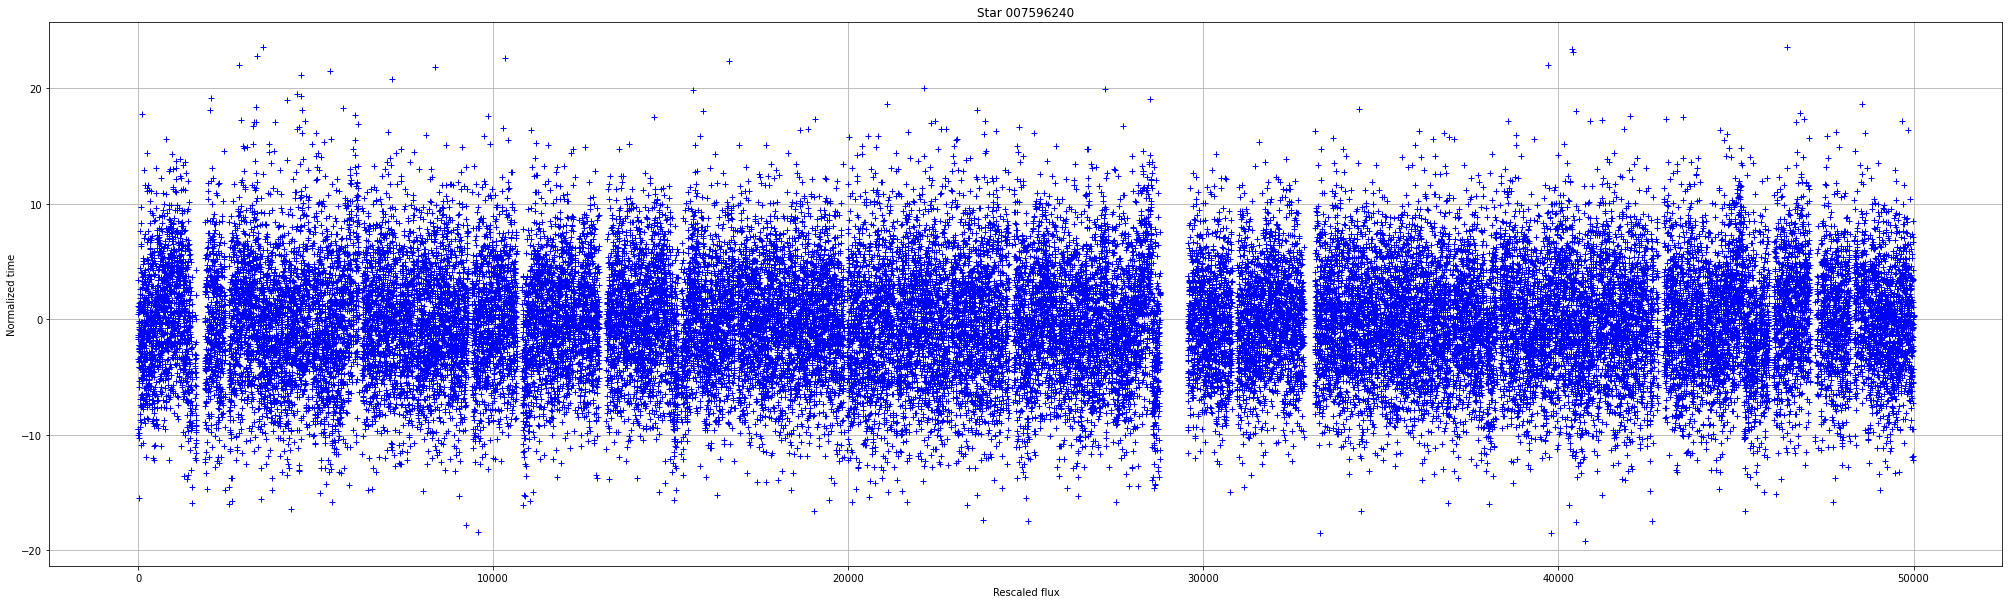

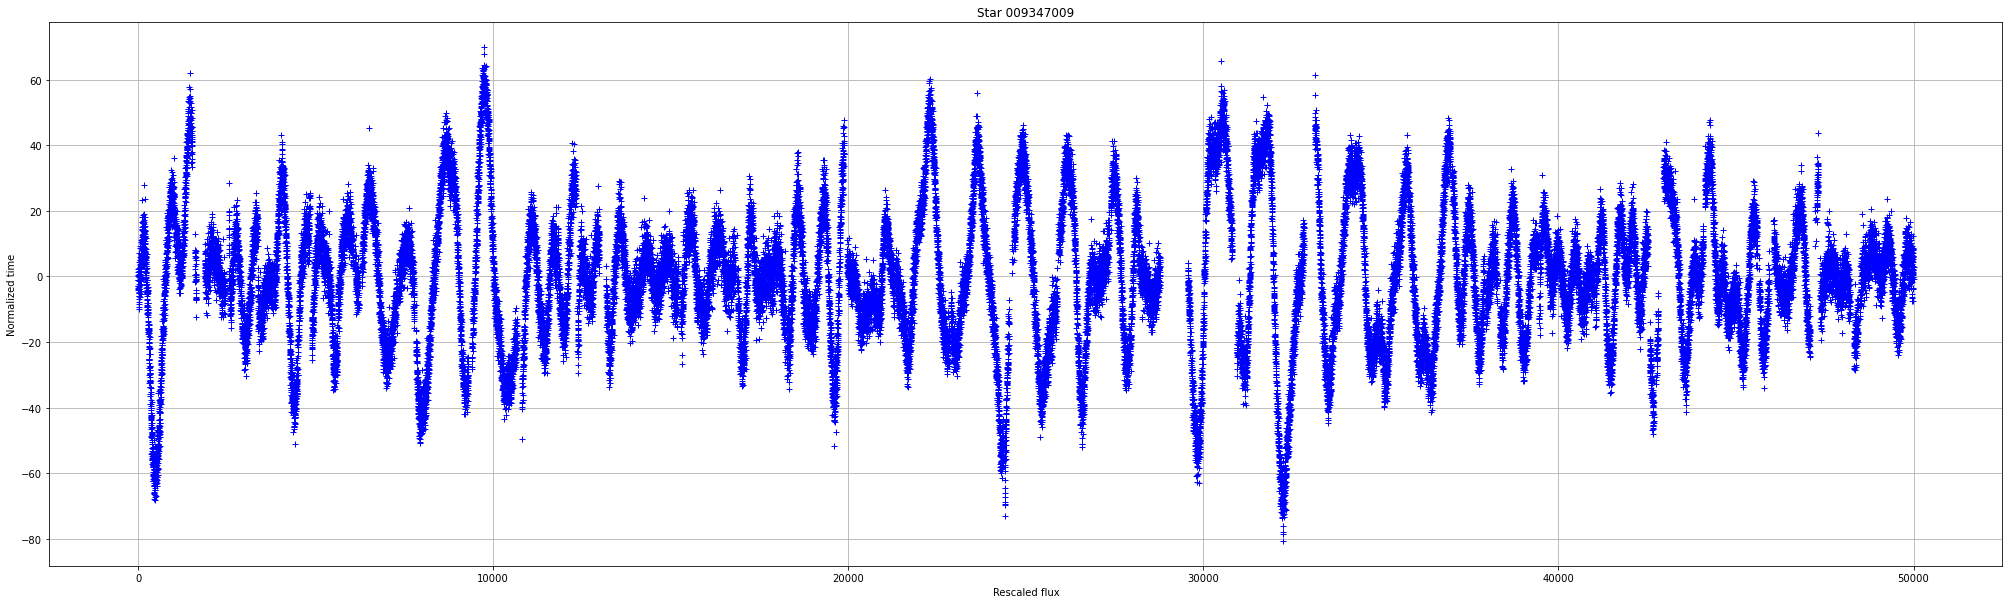

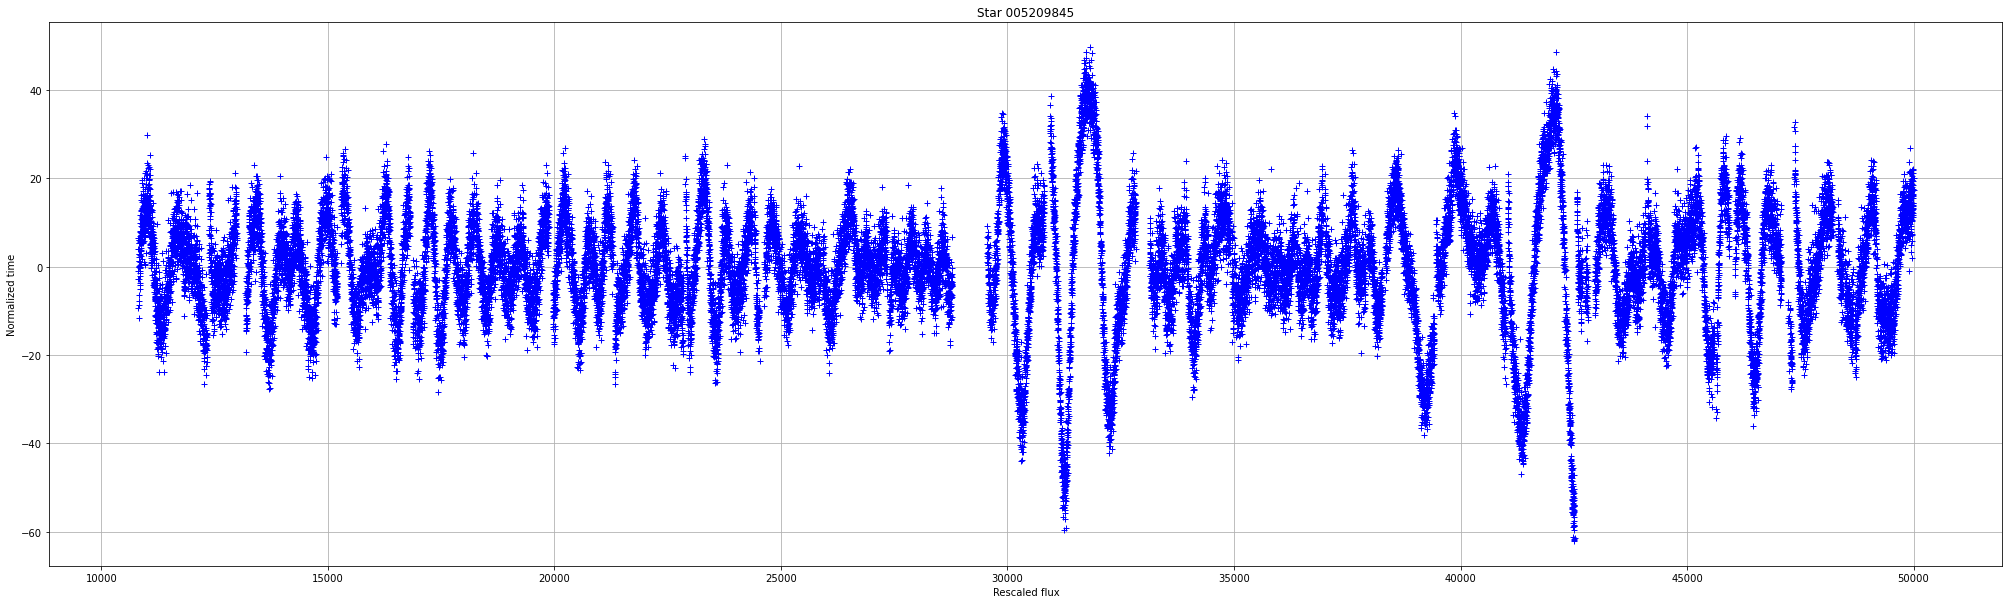

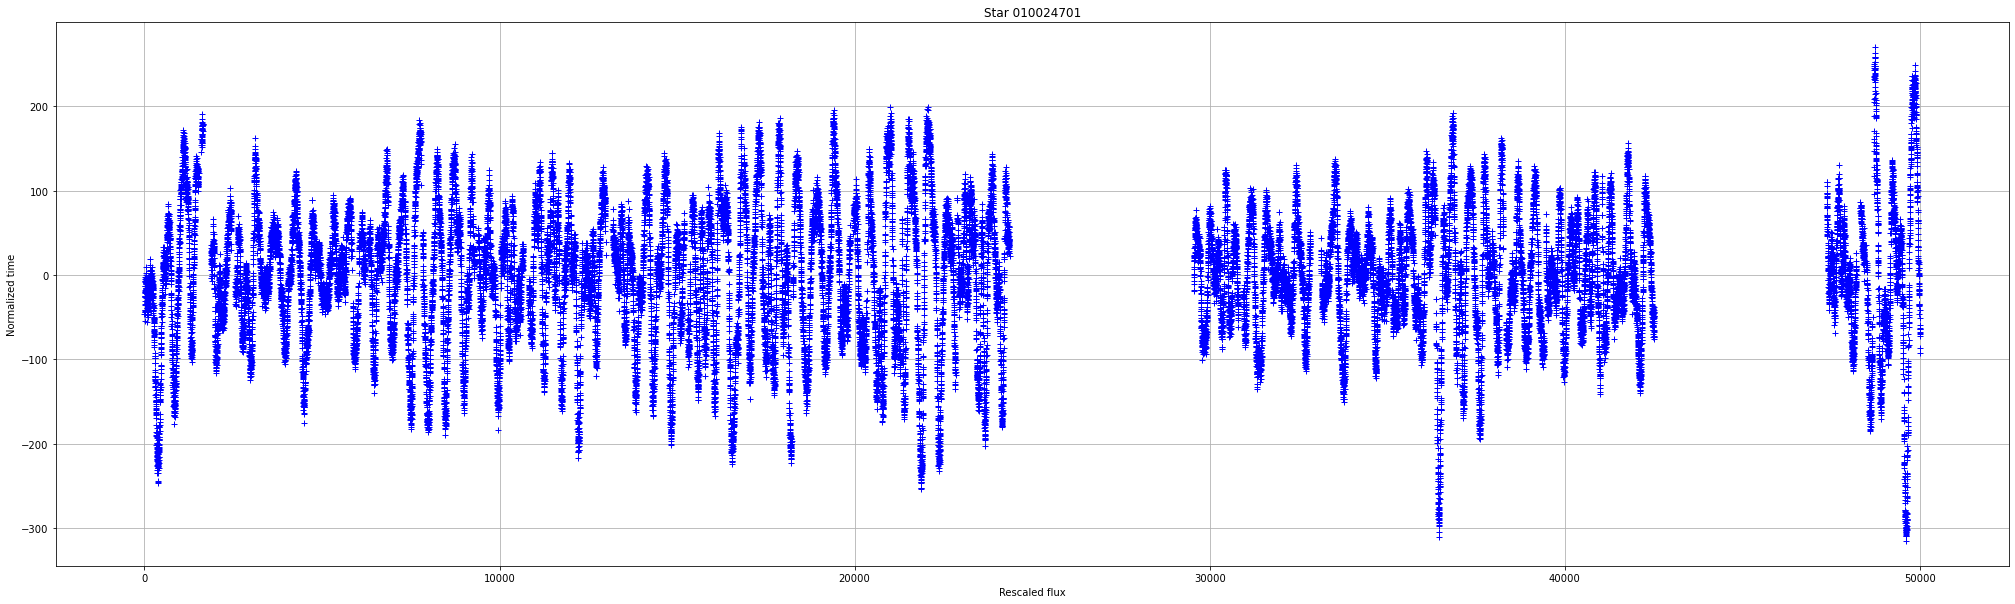

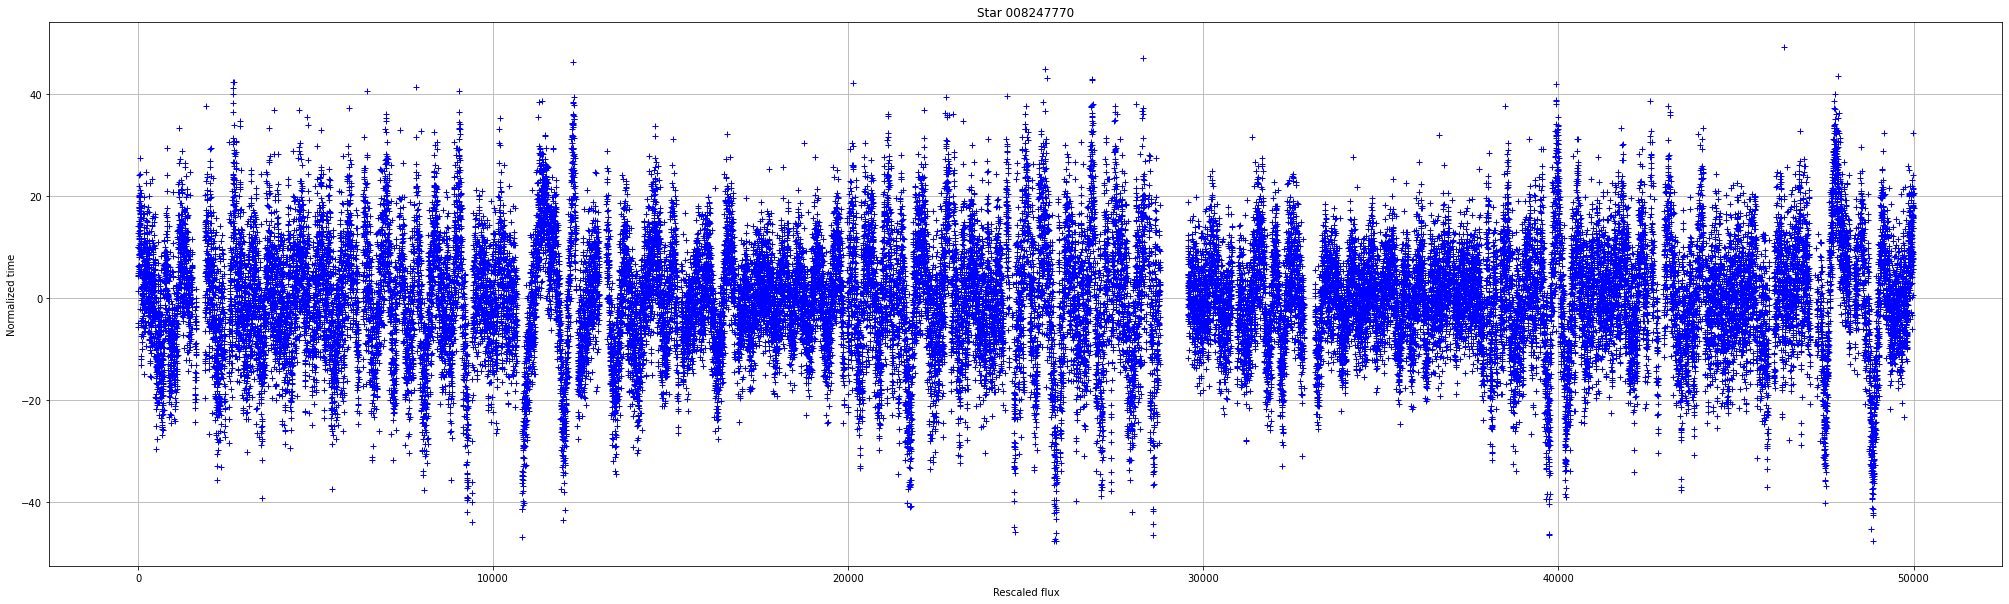

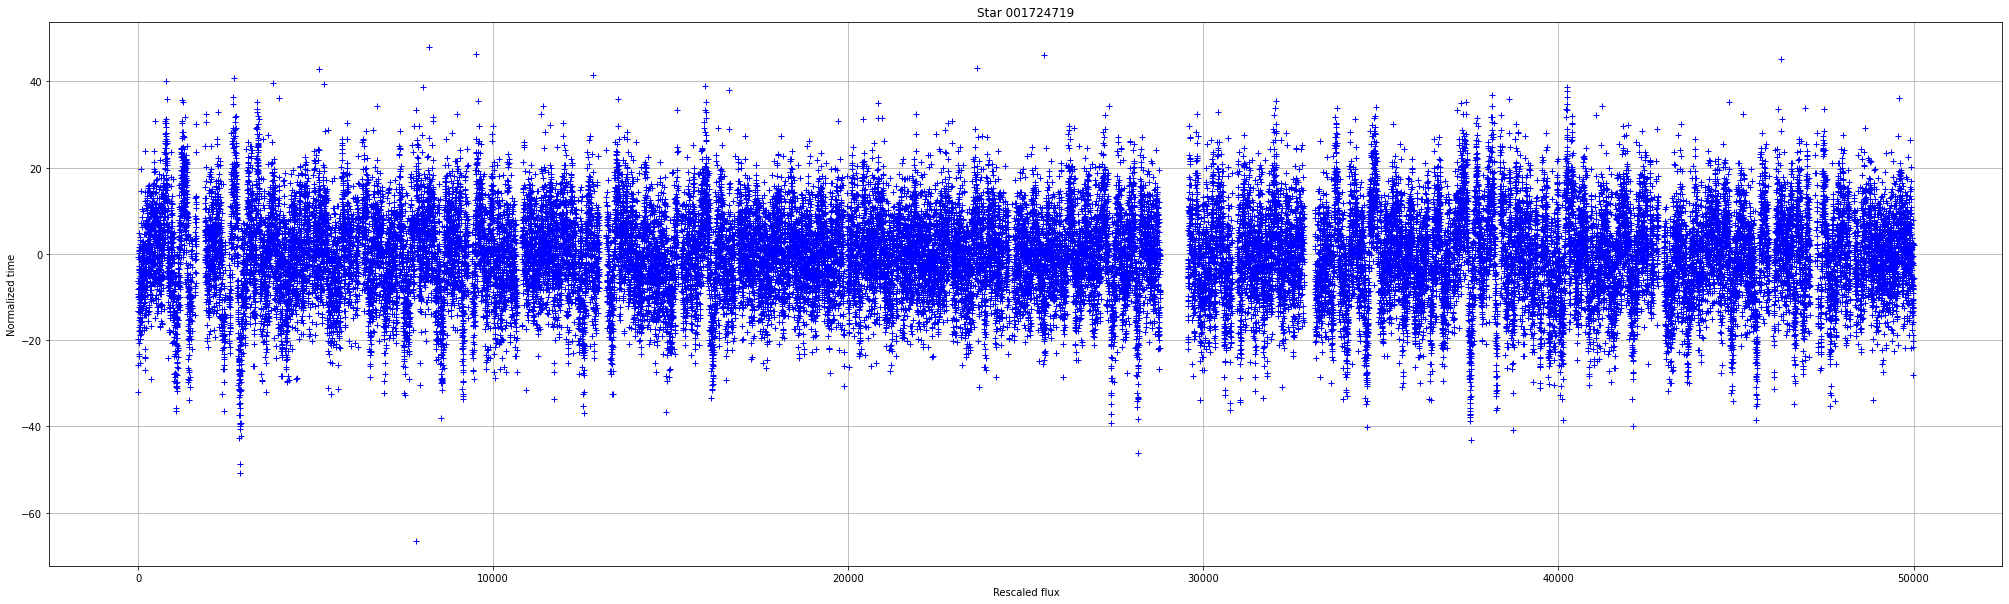

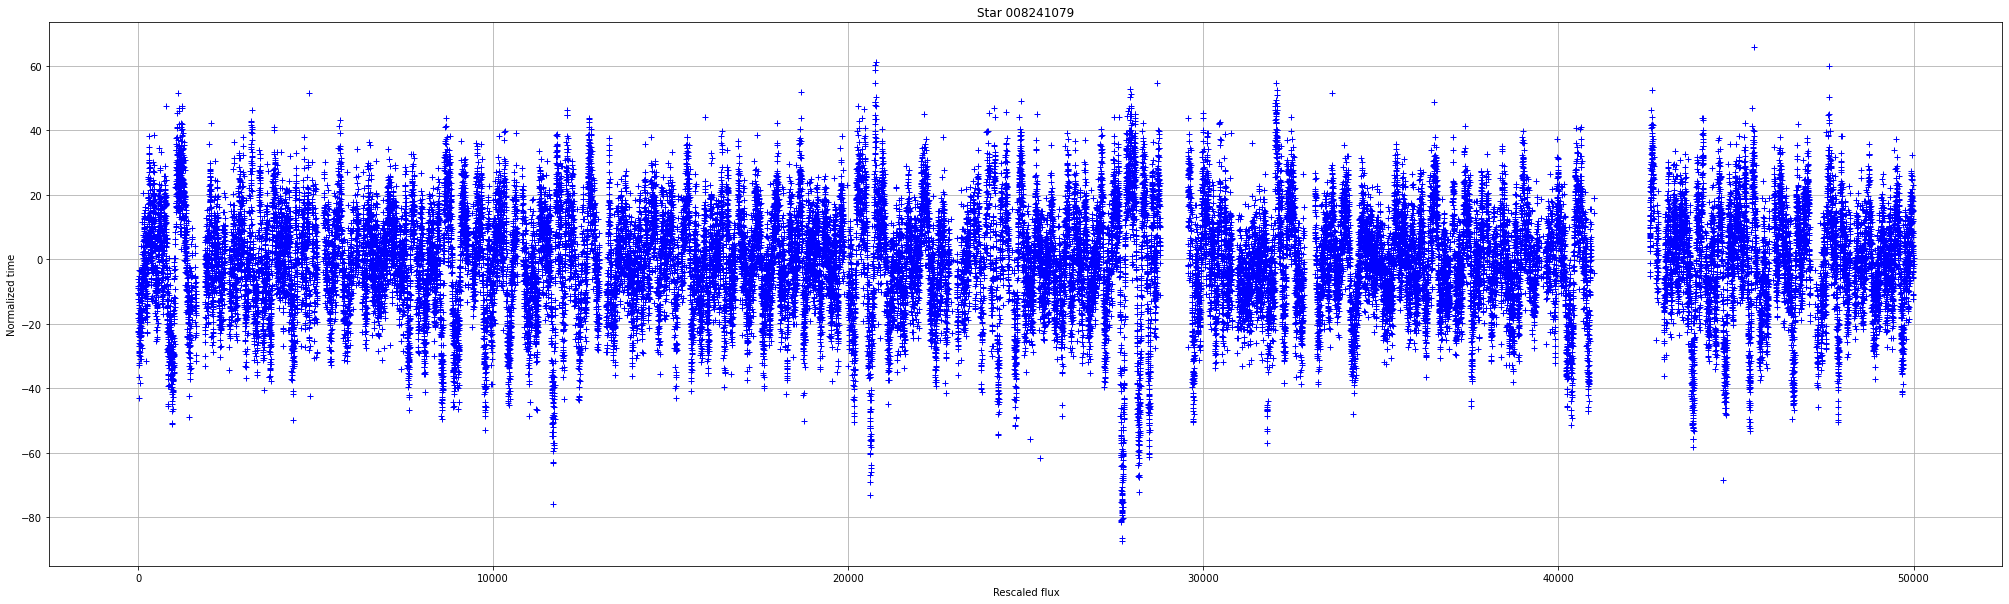

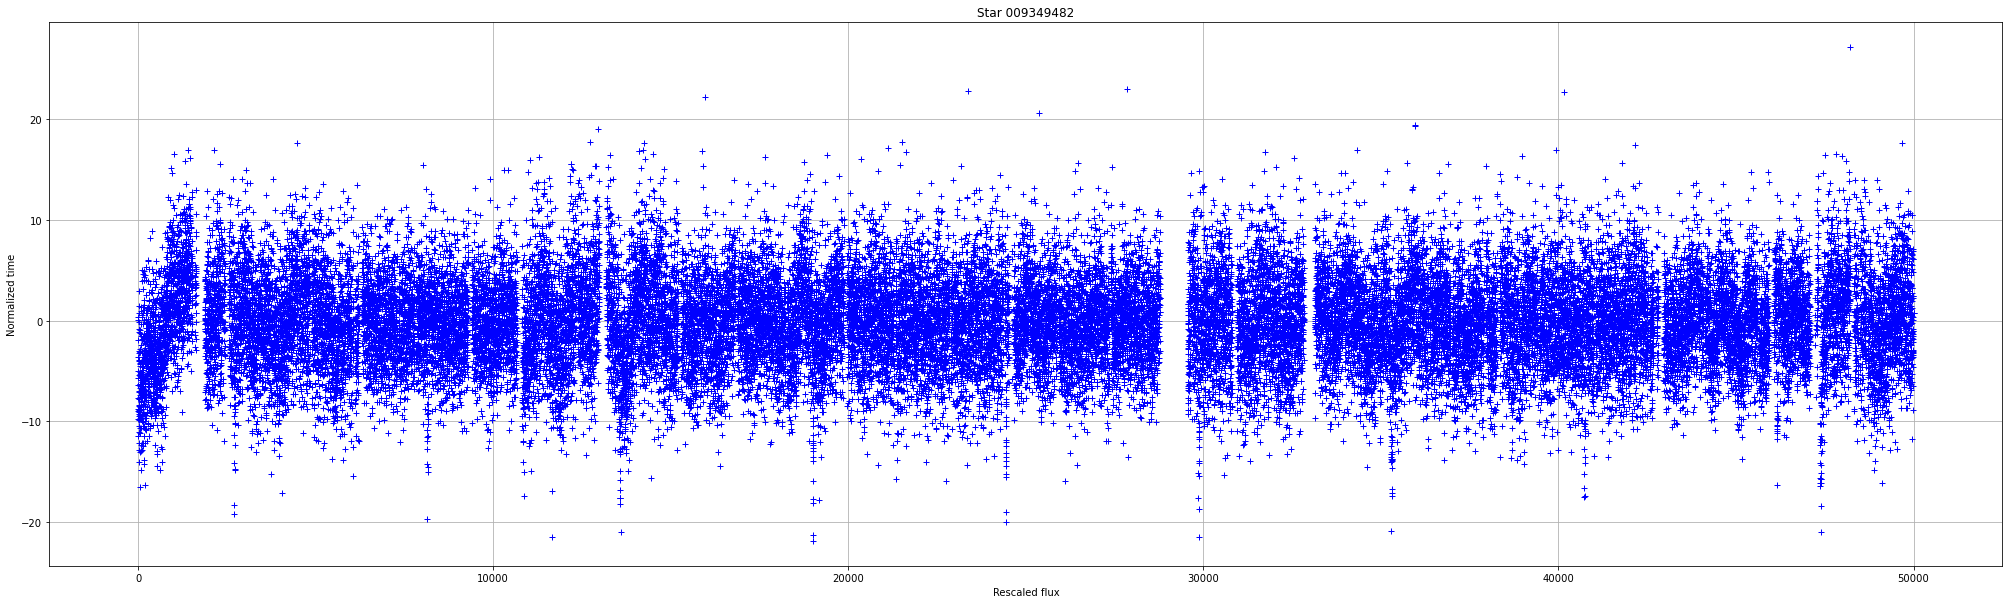

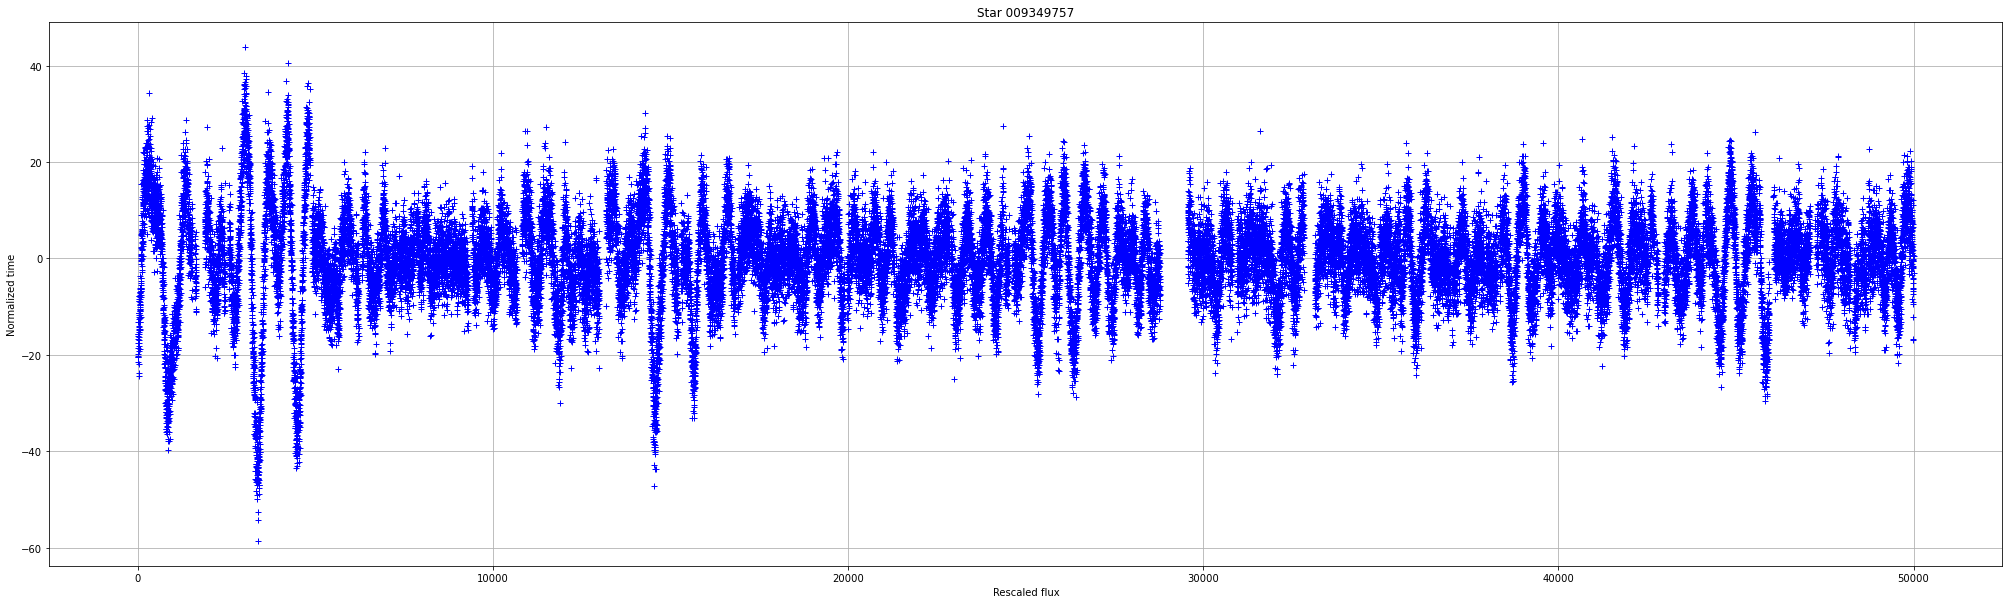

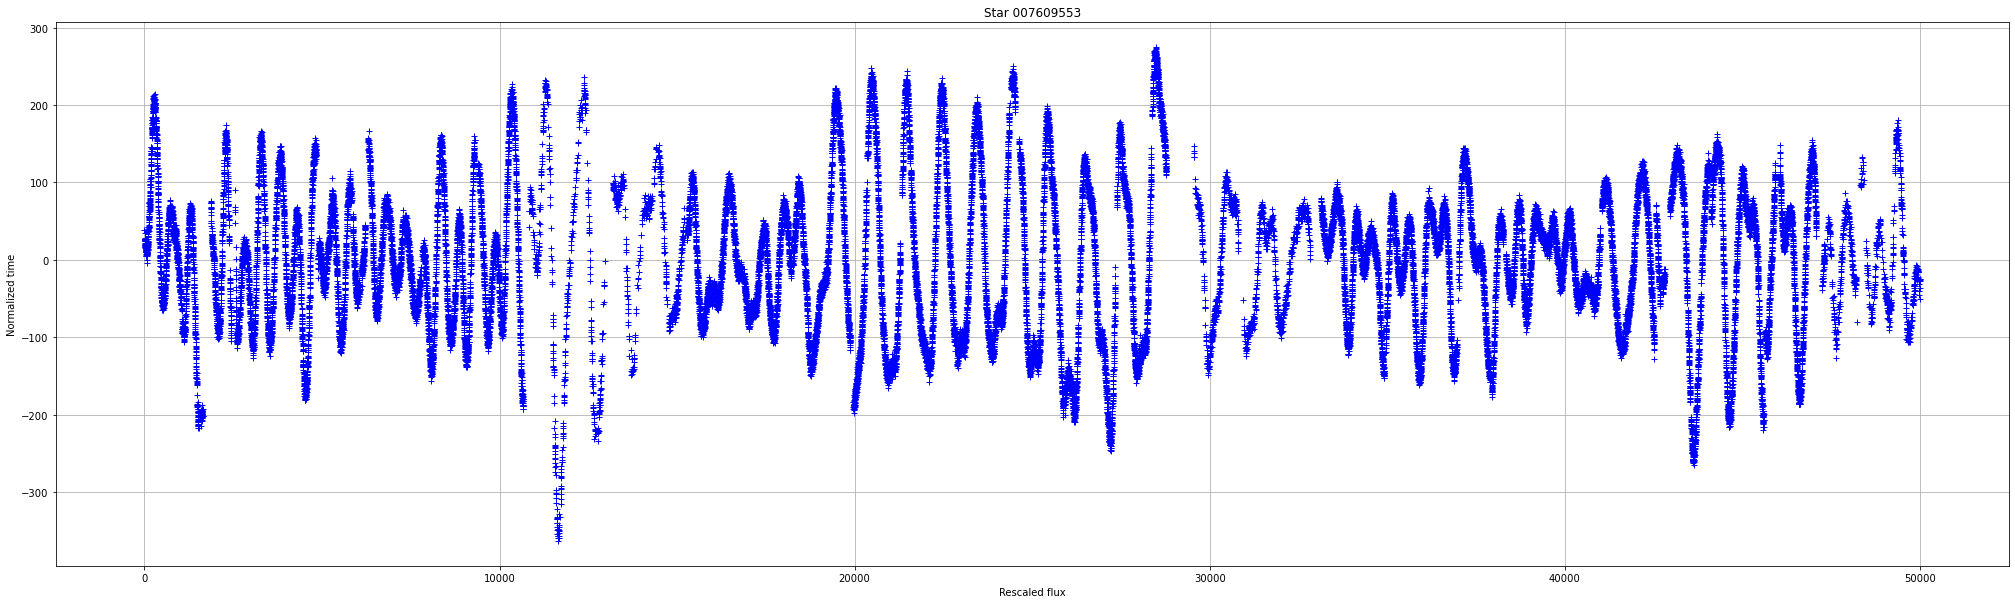

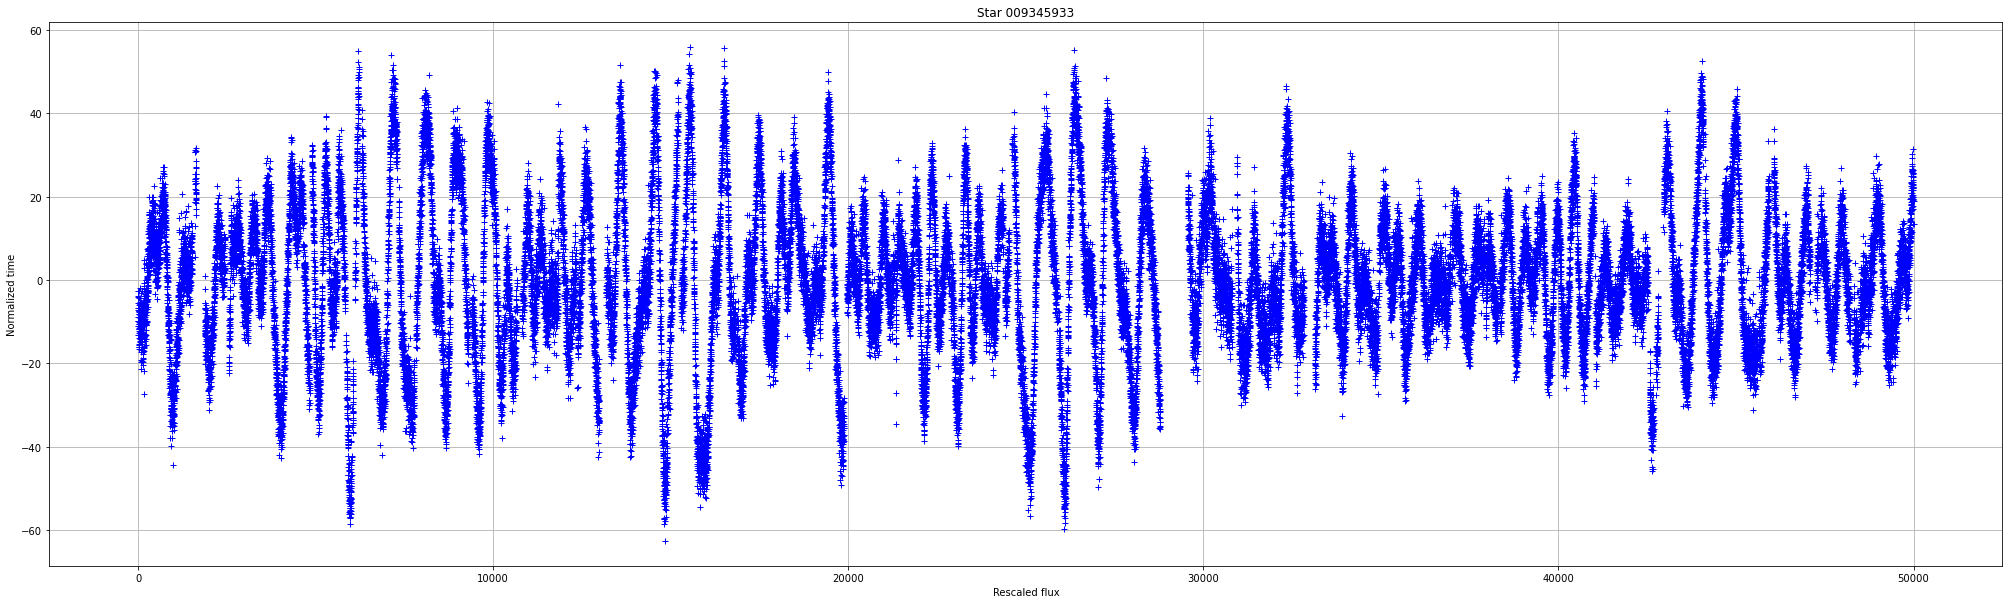

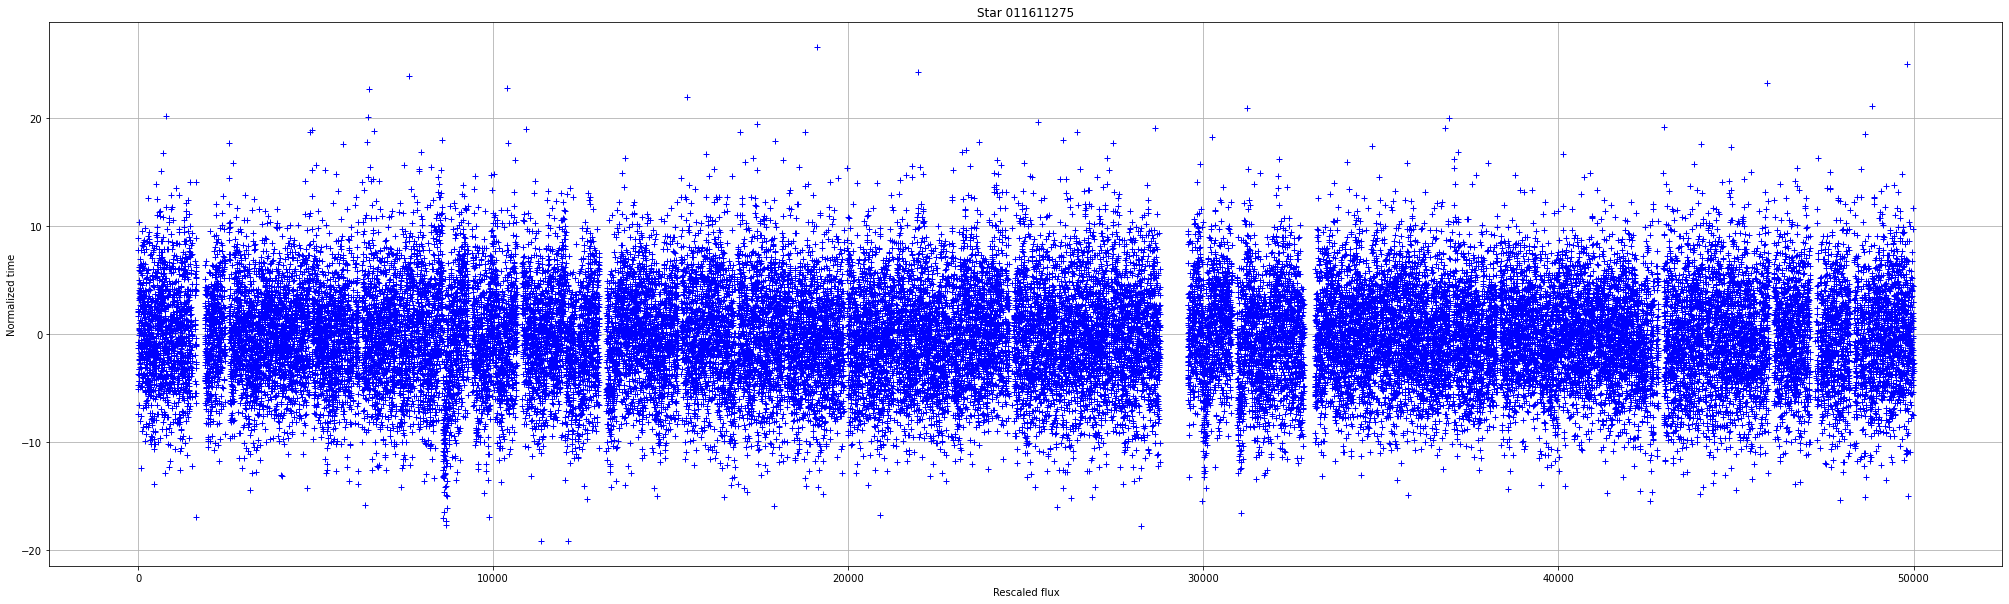

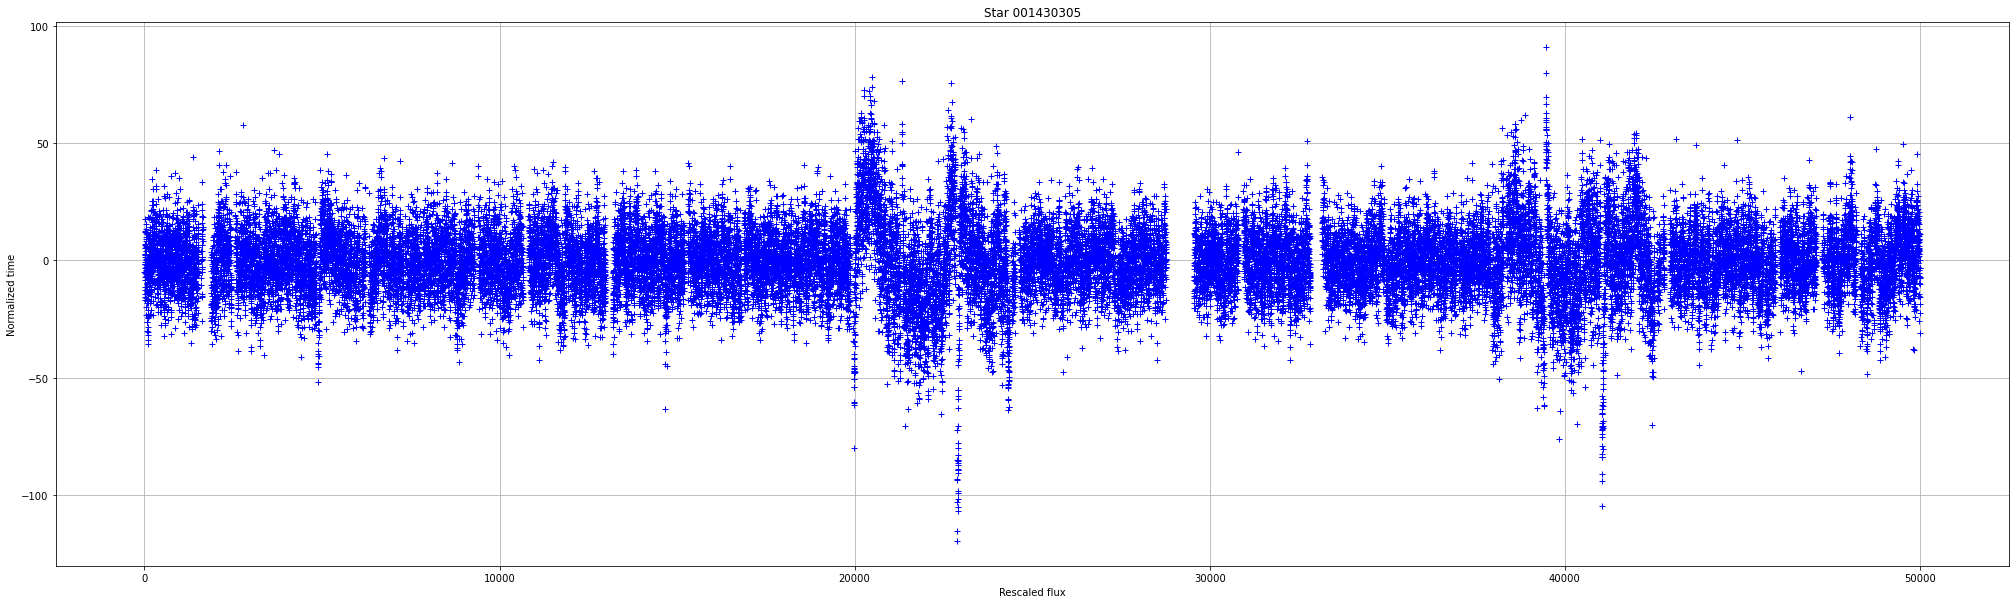

In [10]:
stars = df.columns
stars = list(set([i.split("_")[0] for i in stars]))
print(f"The number of stars available is: {len(stars)}")

for i in tqdm(stars):
    name = i + "_rscl"
    plt.figure(figsize=(35, 10))
    plt.plot(df.index[:50000], df[name][:50000], "b+")
    plt.title("Star " + i)
    plt.xlabel("Rescaled flux")
    plt.ylabel("Normalized time")
    plt.grid(True)
    plt.savefig("lightcurve_" + i + ".jpeg")

Pretty amazing no? Like we see, the behavior of the flux for each star is very different, this is very exciting to test different models to predict the holes in the time series. But, most of this flux cannot be used directly. We need to clean a little the data points.

# Clean the data

## Mean on predefined number of point

In [11]:
def mean_windows(time, flux, lag=5):
    """
    This function denoise the data naively by make a mean between lag number points.
    @param time: (list) list of time values
    @param flux: (list) list of floats -> flux of the star
    @param lag: (int) number of points for the mean, default 5
    @return X: (list) time rescaled
    @return y: (list) flux rescaled by mean
    @return y_std: (list) list of standard deviations for each rescaled points
    """
    # let's do some simple code
    # Empty lists
    X = []
    y = []
    y_std = []
    j = 0  # increment
    for i in range(int(len(flux) / lag)):
        X.append(np.mean(time[(i + j) : (i + j + lag)]))
        y.append(np.mean(flux[(i + j) : (i + j + lag)]))
        y_std.append(np.std(flux[(i + j) : (i + j + lag)]))
        j += lag

    return X, y, y_std

Thats a pretty simple function, you pass your data and specified the number of points you want to use for the mean. Now let's take a look with one noisy star (not too noisy) the star 001724719.

reduce the number of points with the mean on 10 points

In [4]:
x, y, y_err = mean_windows(df.index, df["001724719_rscl"], 10)

Now, we can plot the results, the orignal data will be in blue, the reduced data will be in red.

  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/anaconda3/envs/online_portfolio2/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/anaconda3/envs/online_portfolio2/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/online_portfolio2/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/anaconda3/envs/online_portfolio2/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/online_portfolio2/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/anaconda3/envs/online_portfolio2/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: inva

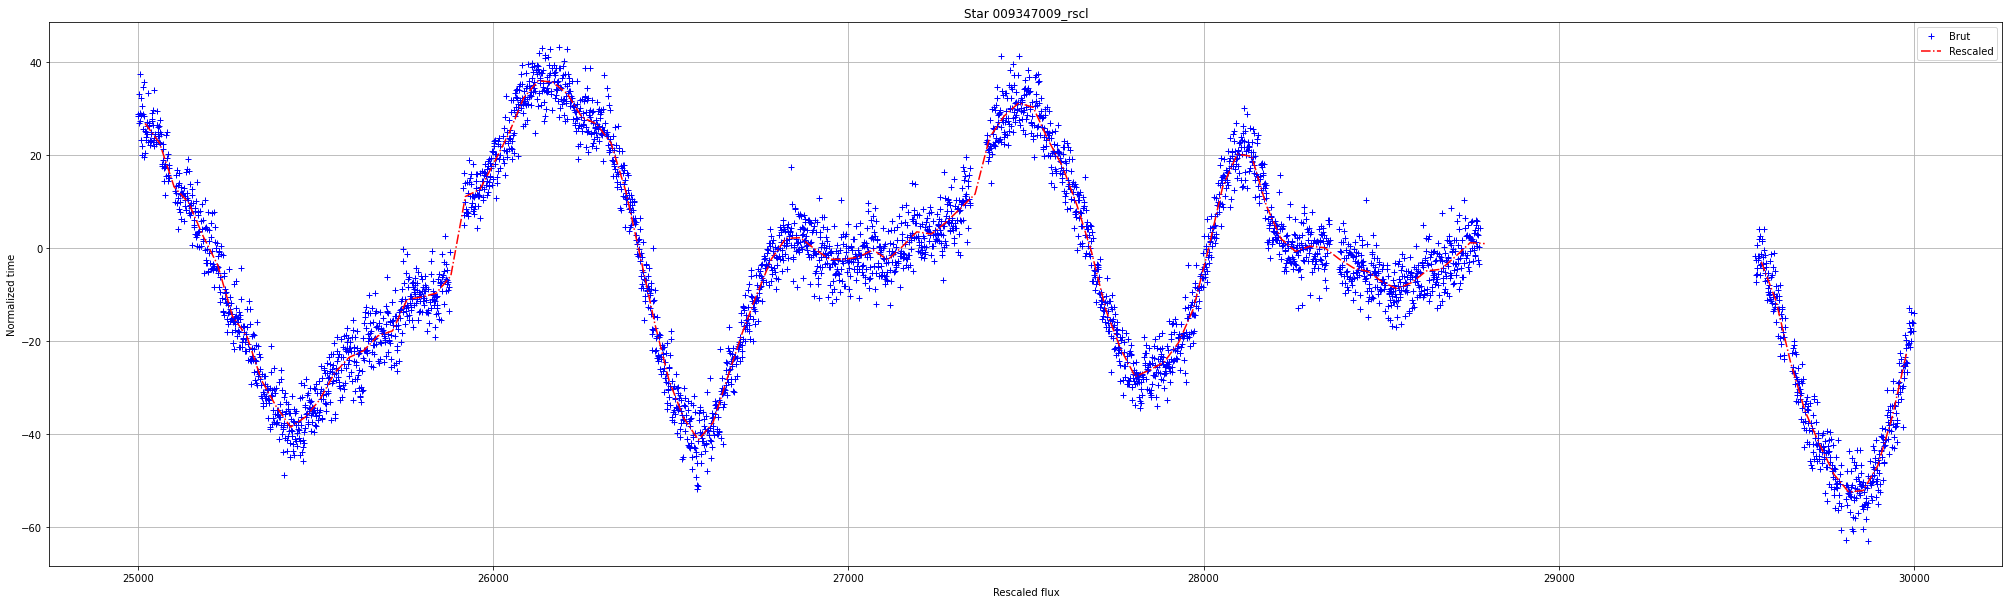

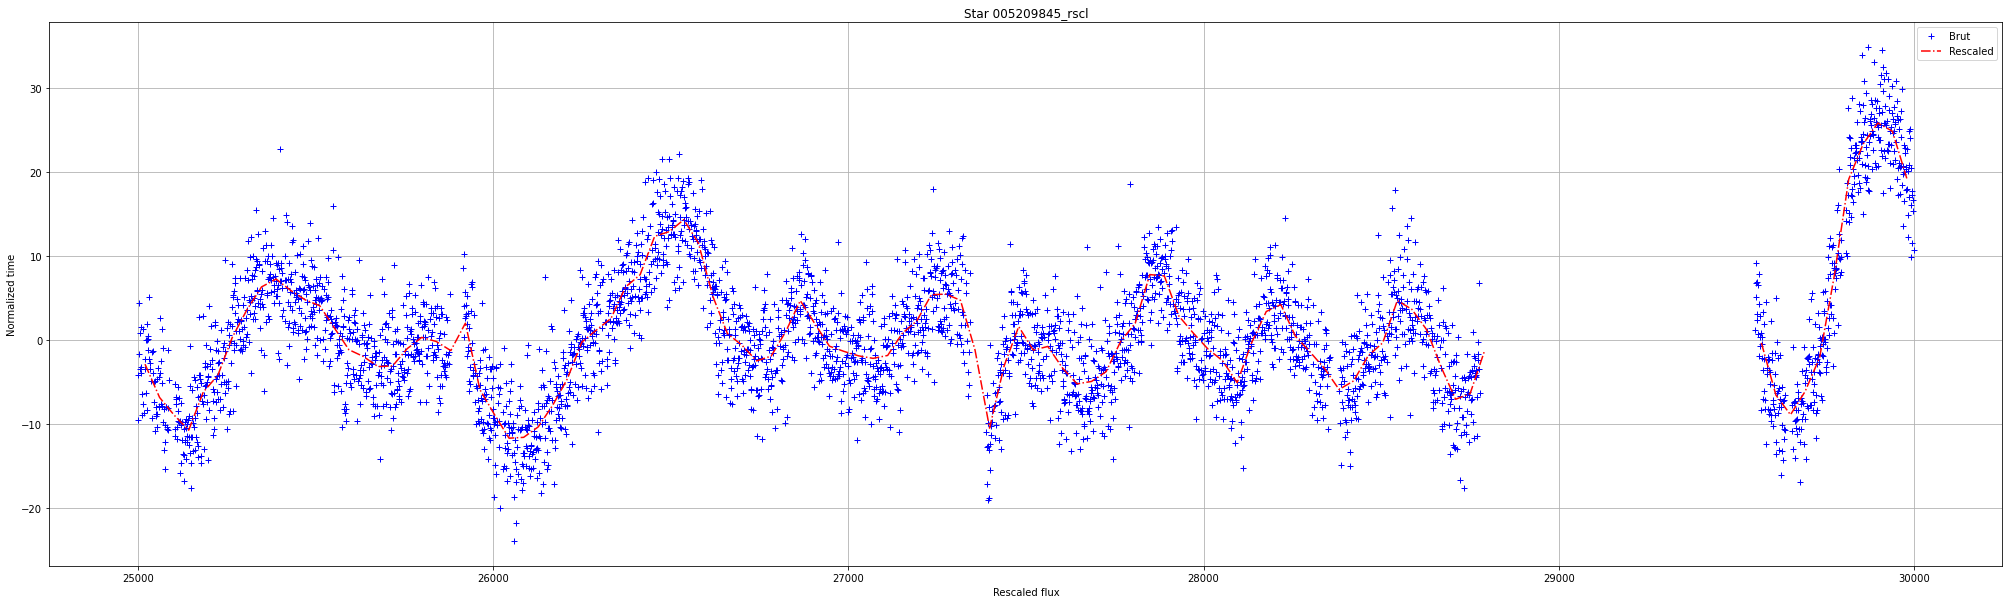

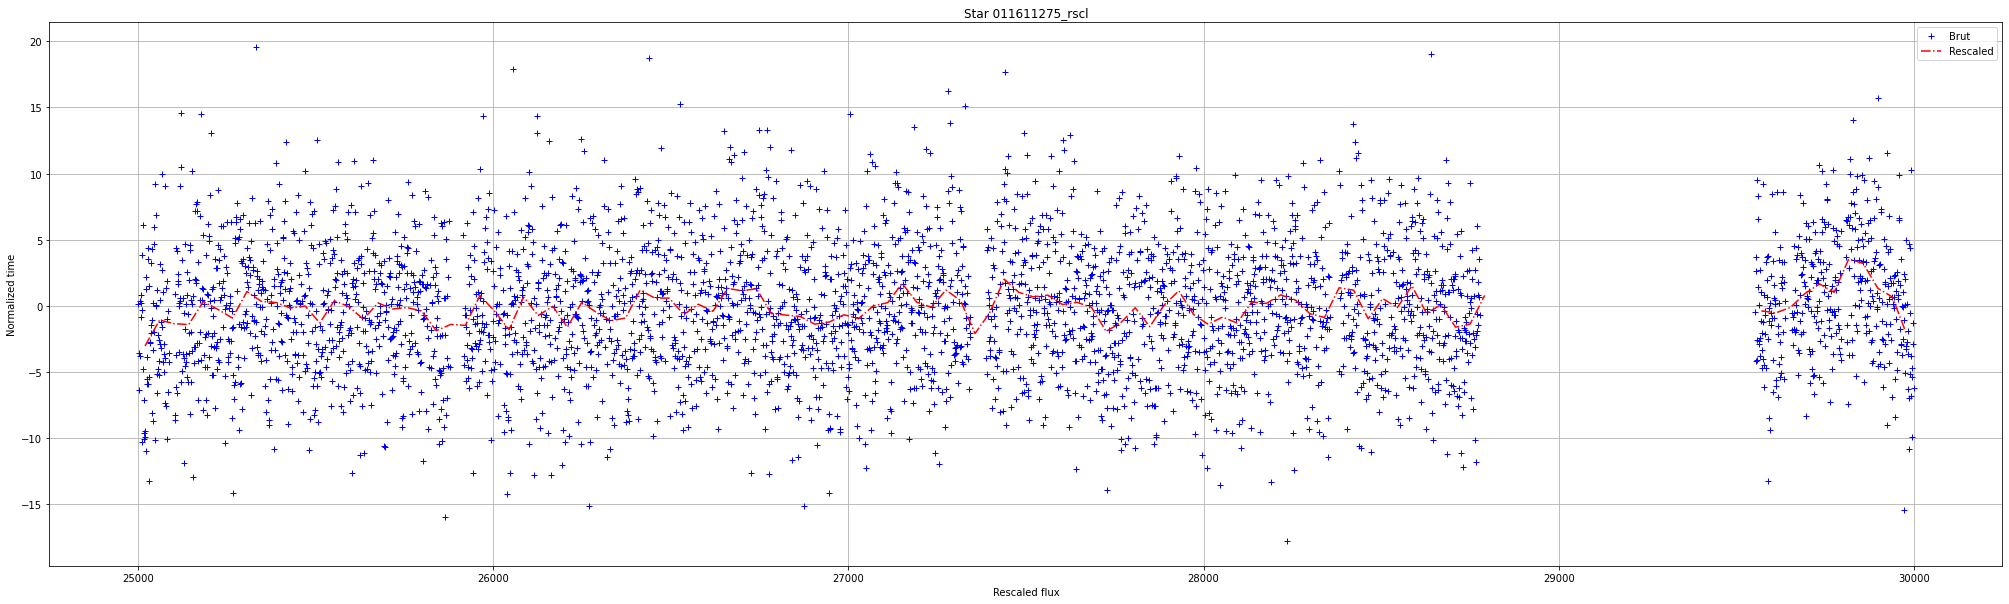

In [13]:
list_ = [1, 2, 11]
for i in tqdm(list_):
    name = stars[i] + "_rscl"
    x, y, y_err = mean_windows(df.index[25000:30000], df[name][25000:30000], 40)
    plt.figure(figsize=(35, 10))

    plt.plot(df.index[25000:30000], df[name][25000:30000], "b+", label="Brut")
    plt.plot(x, y, "r-.", label="Rescaled")
    plt.legend()
    plt.title("Star " + stars[i] + "_rscl")
    plt.xlabel("Rescaled flux")
    plt.ylabel("Normalized time")
    plt.grid(True)
    plt.savefig(stars[i] + "_rscl_mean_window.png", dpi=300)

In [4]:
plt.figure(figsize=(35, 10))
plt.plot(df.index, df["001724719_rscl"], "b+", label="Brut")
plt.plot(x, y, "r-.", label="Rescaled")
plt.legend()
plt.title(f"Star {i}")
plt.xlabel("Rescaled flux")
plt.ylabel("Normalized time")
plt.grid(True)

Well, not very lisible... Let's zoom in a little, plot the first 10,000 points.

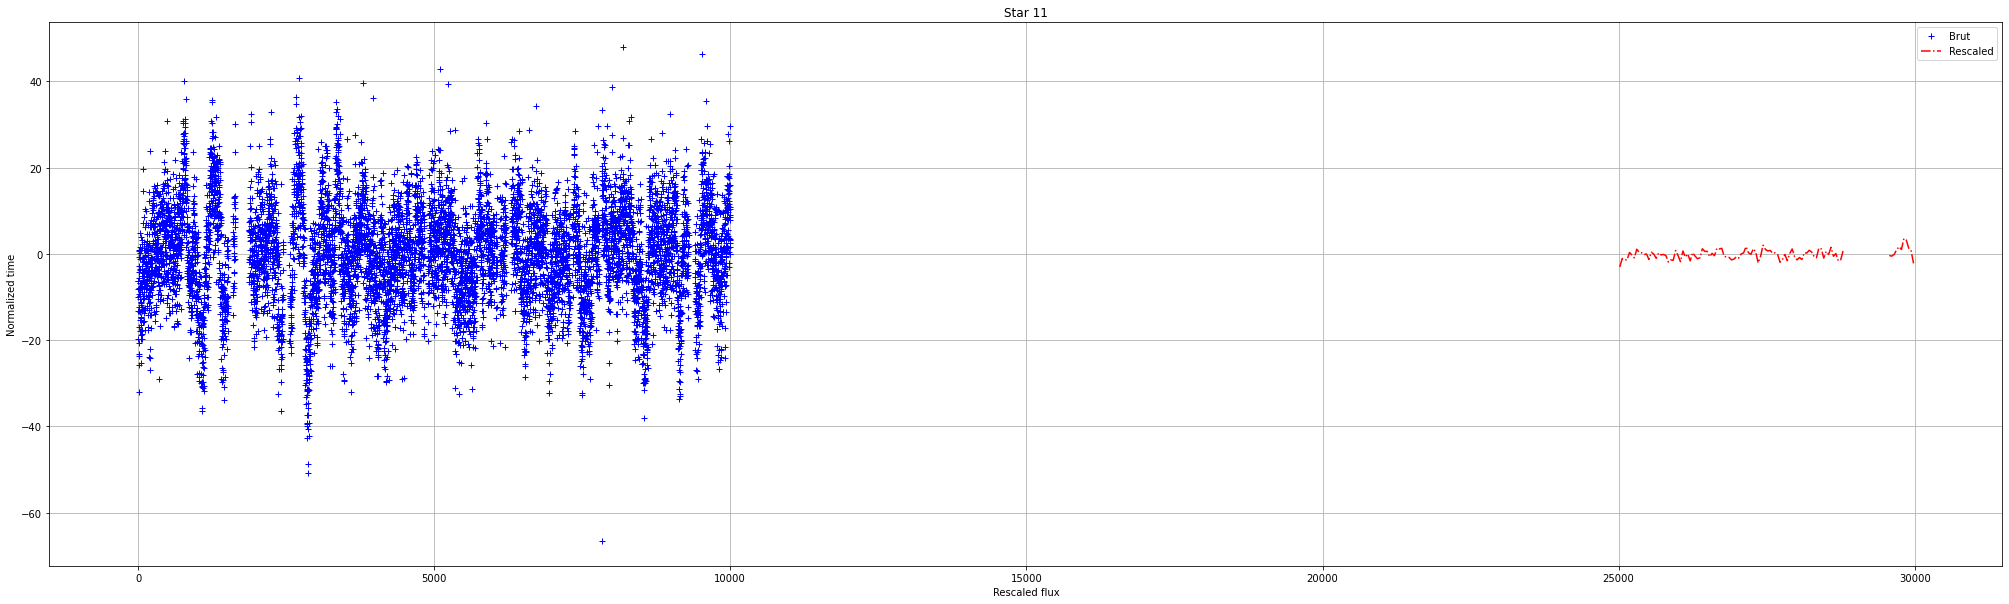

In [14]:
plt.figure(figsize=(35, 10))
plt.plot(df.index[:10000], df["001724719_rscl"][:10000], "b+", label="Brut")
plt.plot(x[:910], y[:910], "r-.", label="Rescaled")
plt.legend()
plt.title(f"Star {i}")
plt.xlabel("Rescaled flux")
plt.ylabel("Normalized time")
plt.grid(True)

Even better, but we always have difficulties to see the result. Let's zoom in again and just show the 2,000 first points.

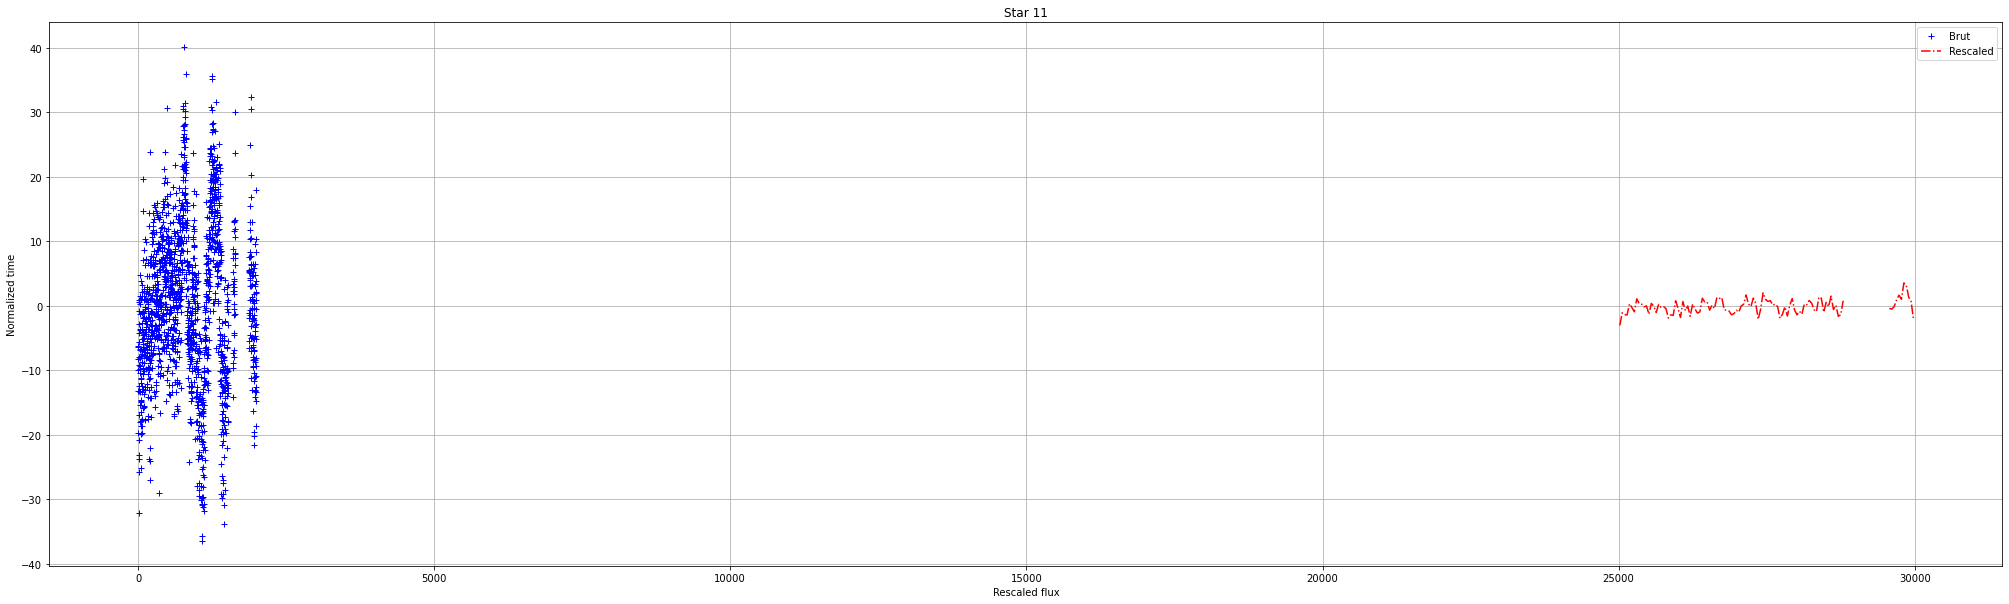

In [16]:
plt.figure(figsize=(35, 10))
plt.plot(df.index[:2000], df["001724719_rscl"][:2000], "b+", label="Brut")
plt.plot(x[:182], y[:182], "r-.", label="Rescaled")
plt.legend()
plt.title(f"Star {i}")
plt.xlabel("Rescaled flux")
plt.ylabel("Normalized time")
plt.grid(True)

Look very good. We can also test other methods to practice this denoising.

In [17]:
## Sliding window

In [19]:
def mean_sliding_windows(time, flux, lag=5):
    """This function denoise the data naively by sliding a window and make a mean between the lag number points.
    @param time: (list) list of time values
    @param flux: (list) list of floats -> flux of the star
    @param lag: (int) number of points for the mean, default 5
    @return X: (list) time rescaled
    @return y: (list) flux rescaled by mean
    @return y_std: (list) list of standard deviations for each rescaled points
    """
    # let's do some simple code
    # Empty lists
    X = []
    y = []
    y_std = []
    j = 0  # increment
    for i in tqdm(range(int(len(flux) - lag))):

        _flux = flux[i : (i + lag)]
        _time = time[i : (i + lag)]
        # _ind = [x[0] for x in enumerate(_flux) if str(x[1]) != 'nan']
        # _time = [np.array(_time)[k] for k in _ind]
        # _flux = [np.array(_flux)[k] for k in _ind]
        # X.append(np.mean(_time) if len(_time)>1 else (_time[0] if len(_time) >0 else np.nan))
        # y.append(np.mean(_flux) if len(_flux)>1 else (_flux[0] if len(_flux) >0 else np.nan))
        # y_std.append(np.std(_flux) if len(_flux)>1 else (_flux[0] if len(_flux) >0 else np.nan))
        X.append(np.mean(_time))
        y.append(np.mean(_flux))
        y_std.append(np.std(_flux))

        j += 1

    return X, y, y_std

In [20]:
%%time
# reduce the number of points with the mean on 10 points
x_slide, y_slide, y_err_slide = mean_sliding_windows(df.index, df["001724719_rscl"], 20)

  0%|          | 0/71407 [00:00<?, ?it/s]

CPU times: user 15.7 s, sys: 432 ms, total: 16.1 s
Wall time: 15.8 s


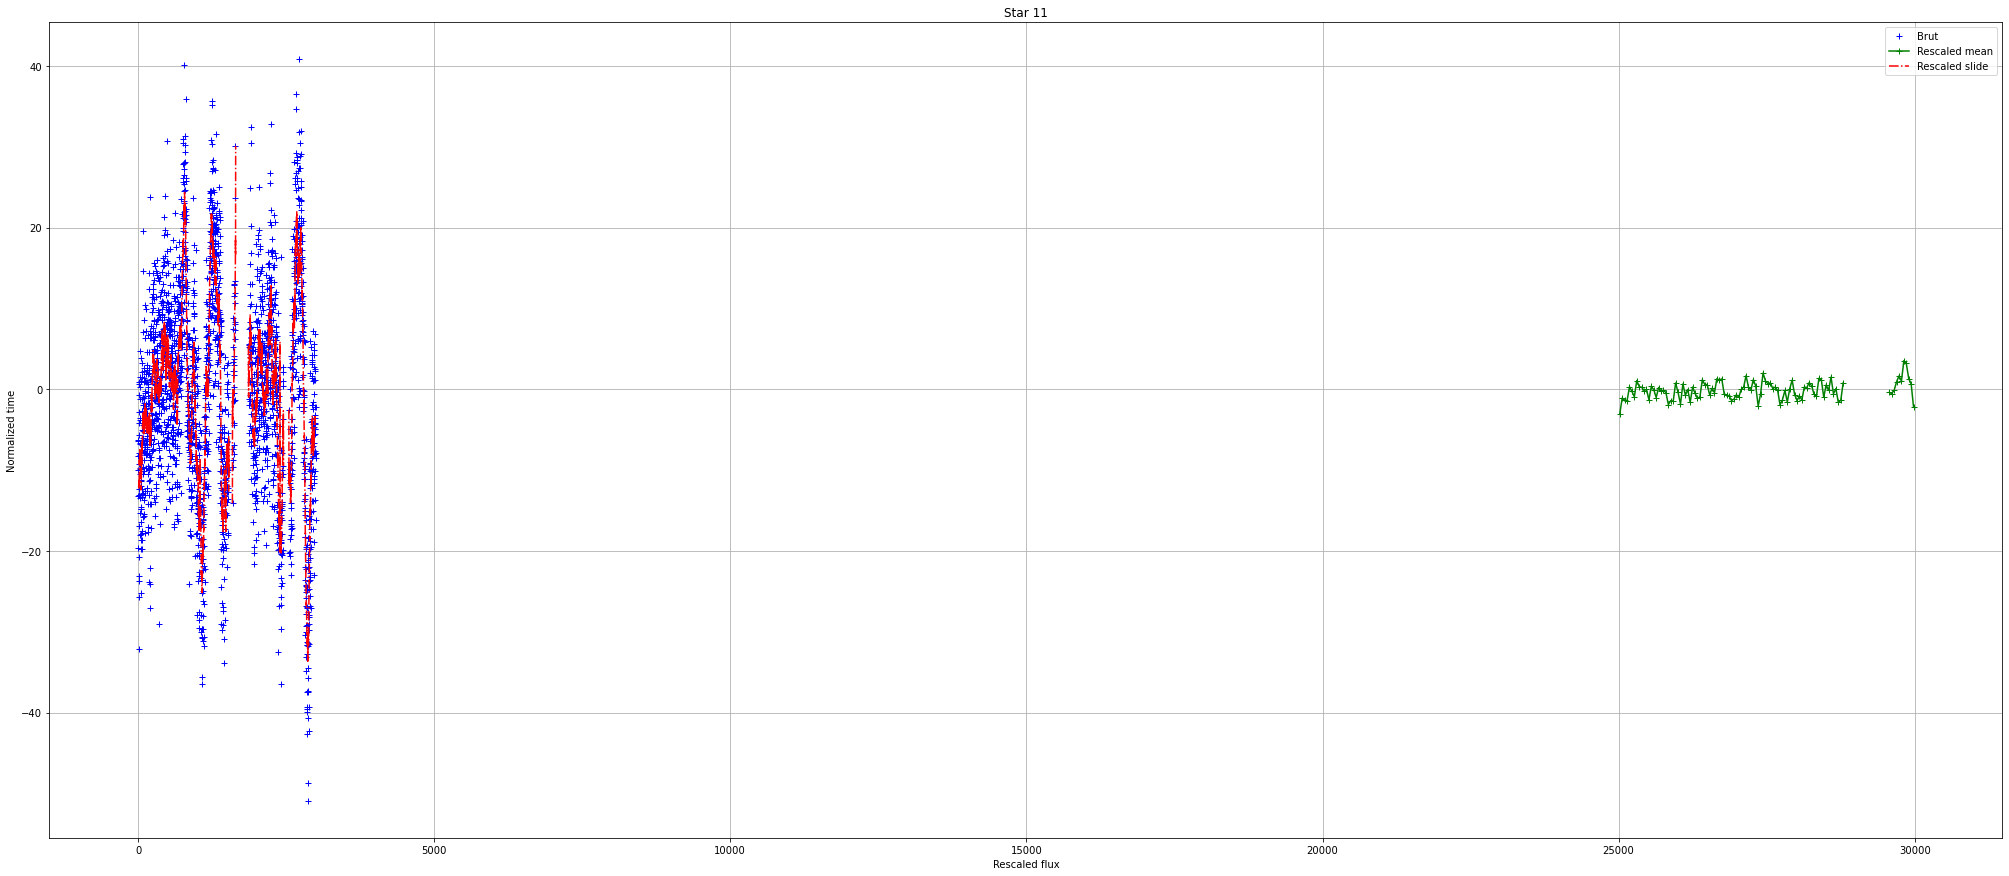

In [21]:
len(x), len(x_slide), len(df.index)

plt.figure(figsize=(35, 15))
plt.plot(df.index[:3000], df["001724719_rscl"][:3000], "b+", label="Brut")
plt.plot(x[:273], y[:273], "g-+", label="Rescaled mean")
plt.plot(x_slide[:2980], y_slide[:2980], "r-.", label="Rescaled slide")
plt.legend()
plt.title(f"Star {i}")
plt.xlabel("Rescaled flux")
plt.ylabel("Normalized time")
plt.grid(True)

Interesting because the slide window permit to keep small fluctuations.

So, here are two methods, we could make a function and apply it to the whole dataset and save into a dataframe.

In [22]:
def reduced_data(df, stars):
    """
    Function to automatically reduced a dataset
    @param df: (pandas dataframe) dataframe containing all the data
    @param stars: (list) list containing the name of each stars we want reduced data
    @return df_mean: dataframe containing the data reduced by the mean function
    @return df_slide: dataframe containing the data reduced by the sliding window method
    """
    df_mean = pd.DataFrame()
    df_slide = pd.DataFrame()
    for i in tqdm(stars):

        x, y, y_std = mean_windows(df.index, df[i + "_rscl"], lag=25)
        df_mean[i + "_rscl_x"] = x
        df_mean[i + "_rscl_y"] = y
        df_mean[i + "_rscl_y_std"] = y_std

        x, y, y_std = mean_sliding_windows(df.index, df[i + "_rscl"], lag=40)
        df_slide[i + "_rscl_x"] = x
        df_slide[i + "_rscl_y"] = y
        df_slide[i + "_rscl_y_std"] = y_std

    return df_mean, df_slide

In [23]:
df_mean, df_slide = reduced_data(df, stars)

  0%|          | 0/13 [00:00<?, ?it/s]

/usr/local/anaconda3/envs/online_portfolio2/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/anaconda3/envs/online_portfolio2/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


  0%|          | 0/71387 [00:00<?, ?it/s]

  0%|          | 0/71387 [00:00<?, ?it/s]

  0%|          | 0/71387 [00:00<?, ?it/s]

  0%|          | 0/71387 [00:00<?, ?it/s]

  0%|          | 0/71387 [00:00<?, ?it/s]

  0%|          | 0/71387 [00:00<?, ?it/s]

  0%|          | 0/71387 [00:00<?, ?it/s]

  0%|          | 0/71387 [00:00<?, ?it/s]

  0%|          | 0/71387 [00:00<?, ?it/s]

  0%|          | 0/71387 [00:00<?, ?it/s]

  0%|          | 0/71387 [00:00<?, ?it/s]

  0%|          | 0/71387 [00:00<?, ?it/s]

  0%|          | 0/71387 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

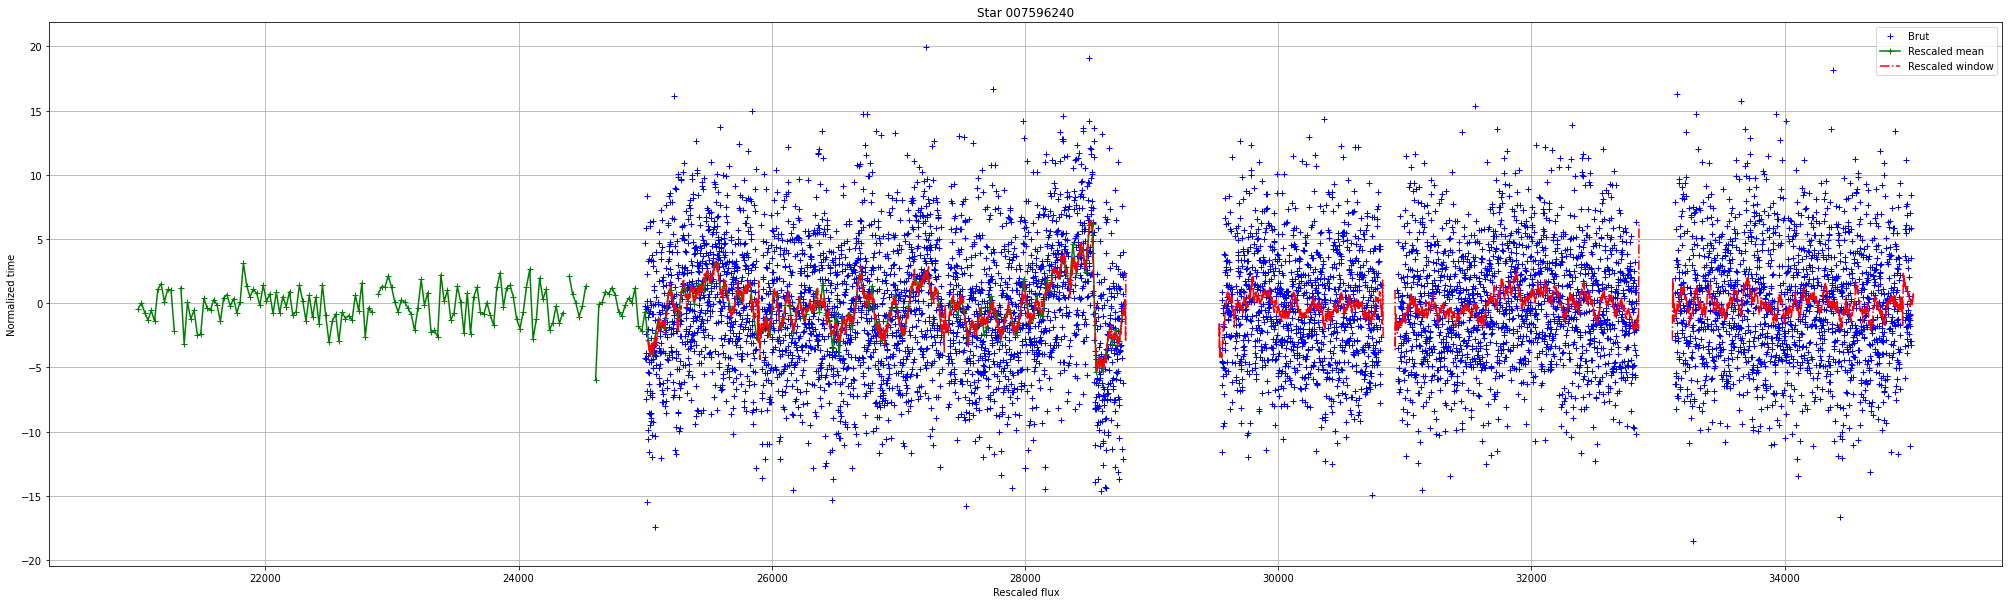

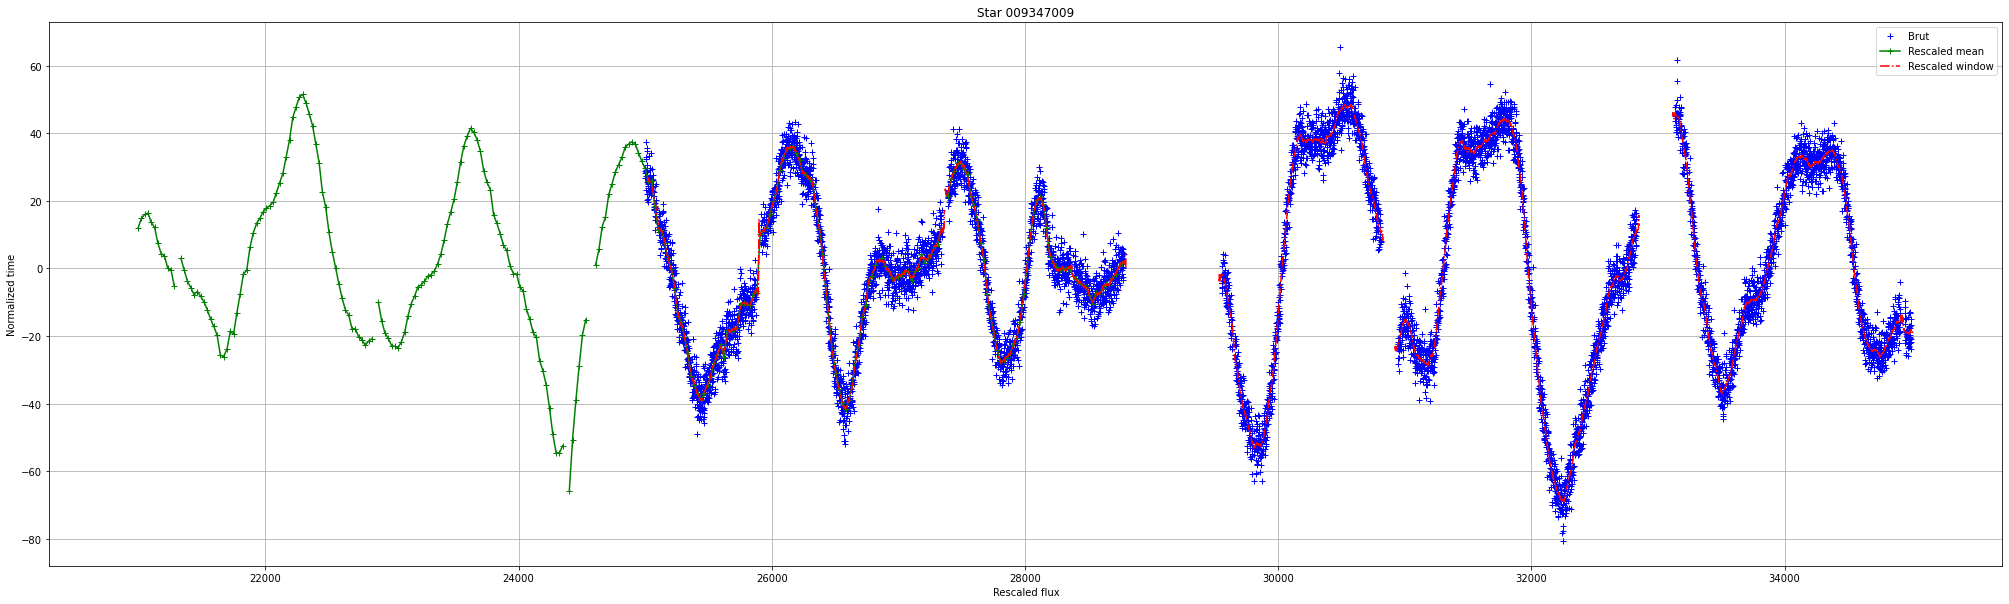

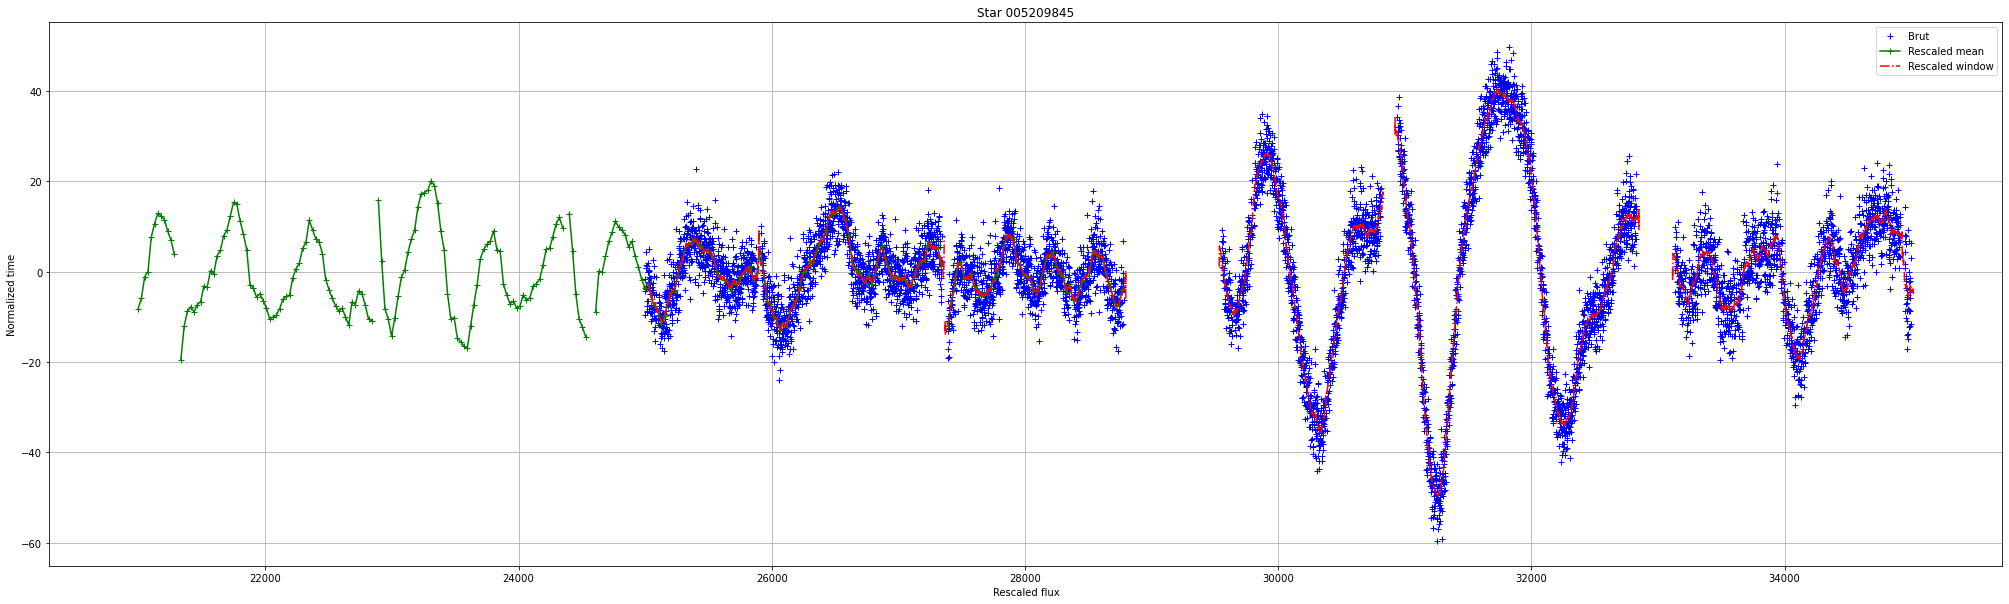

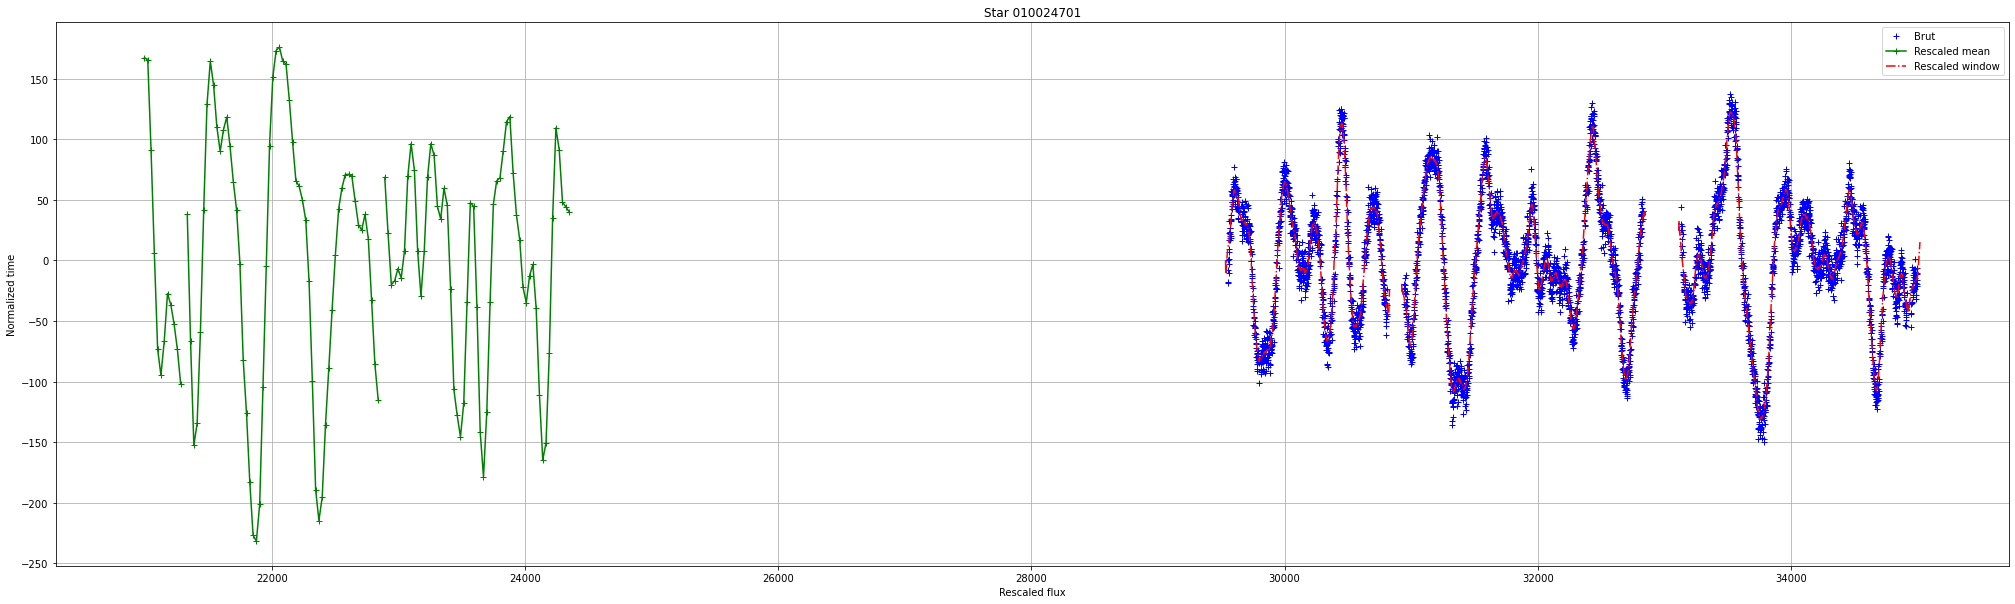

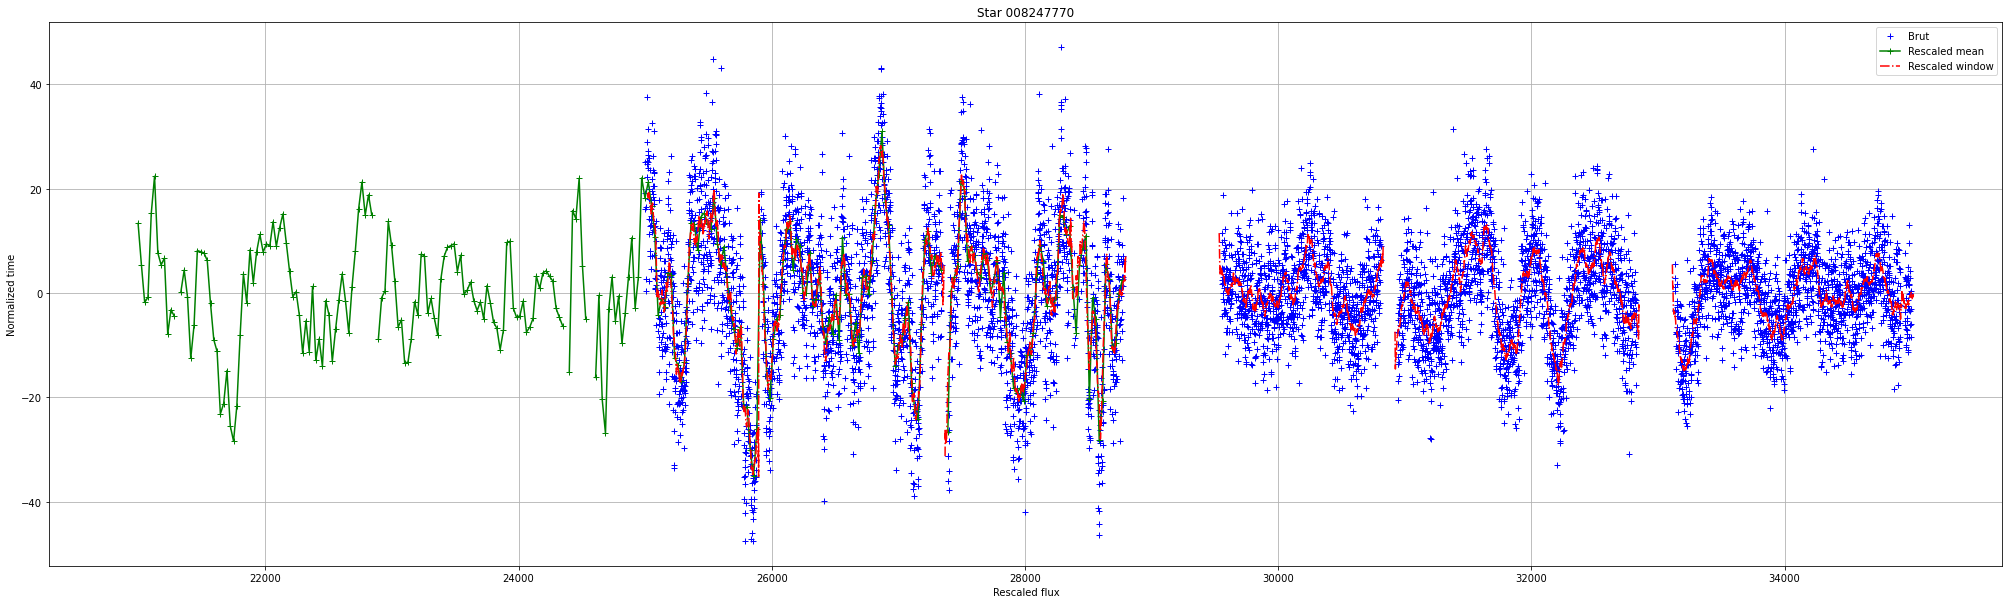

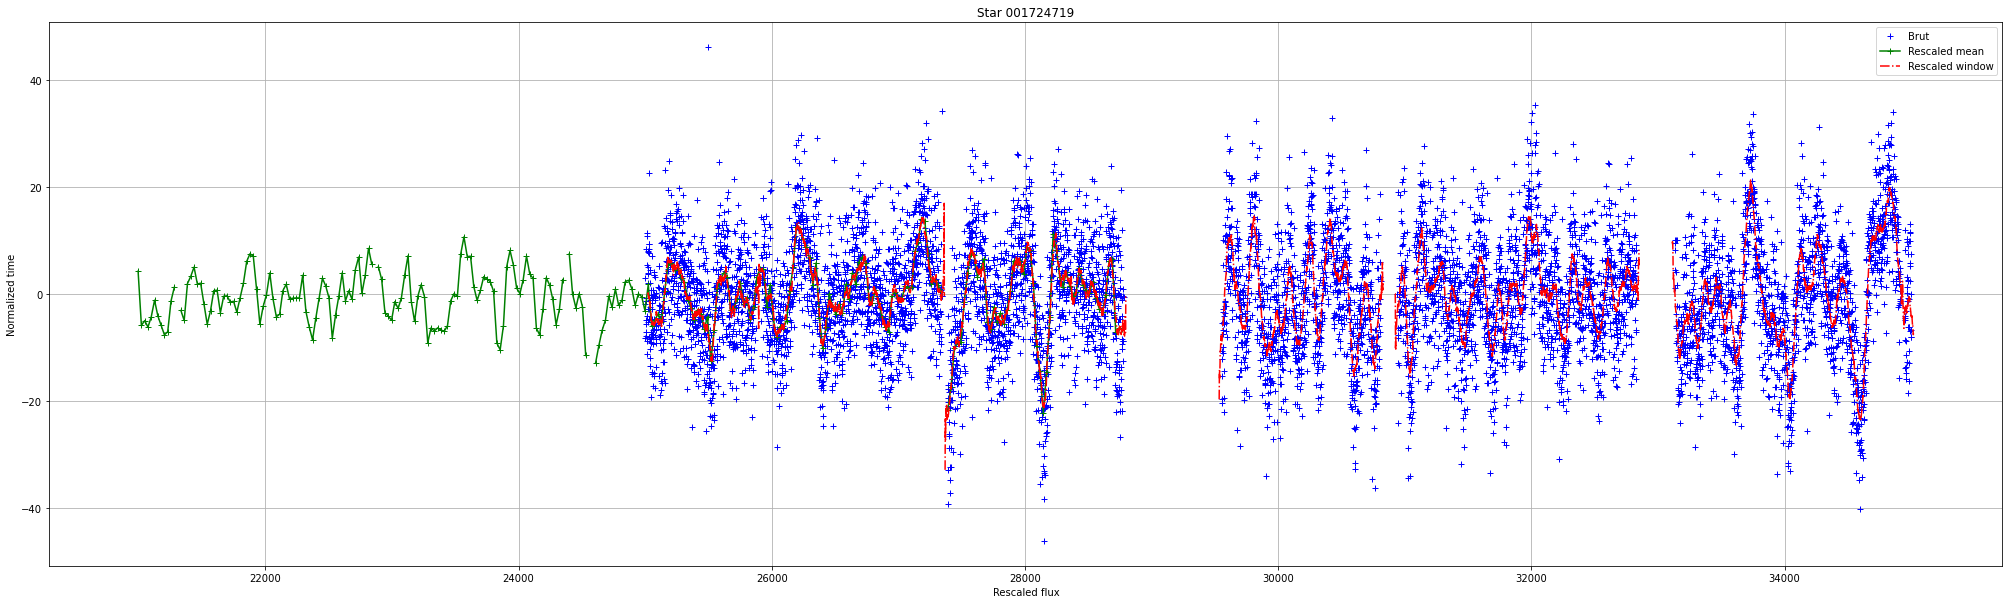

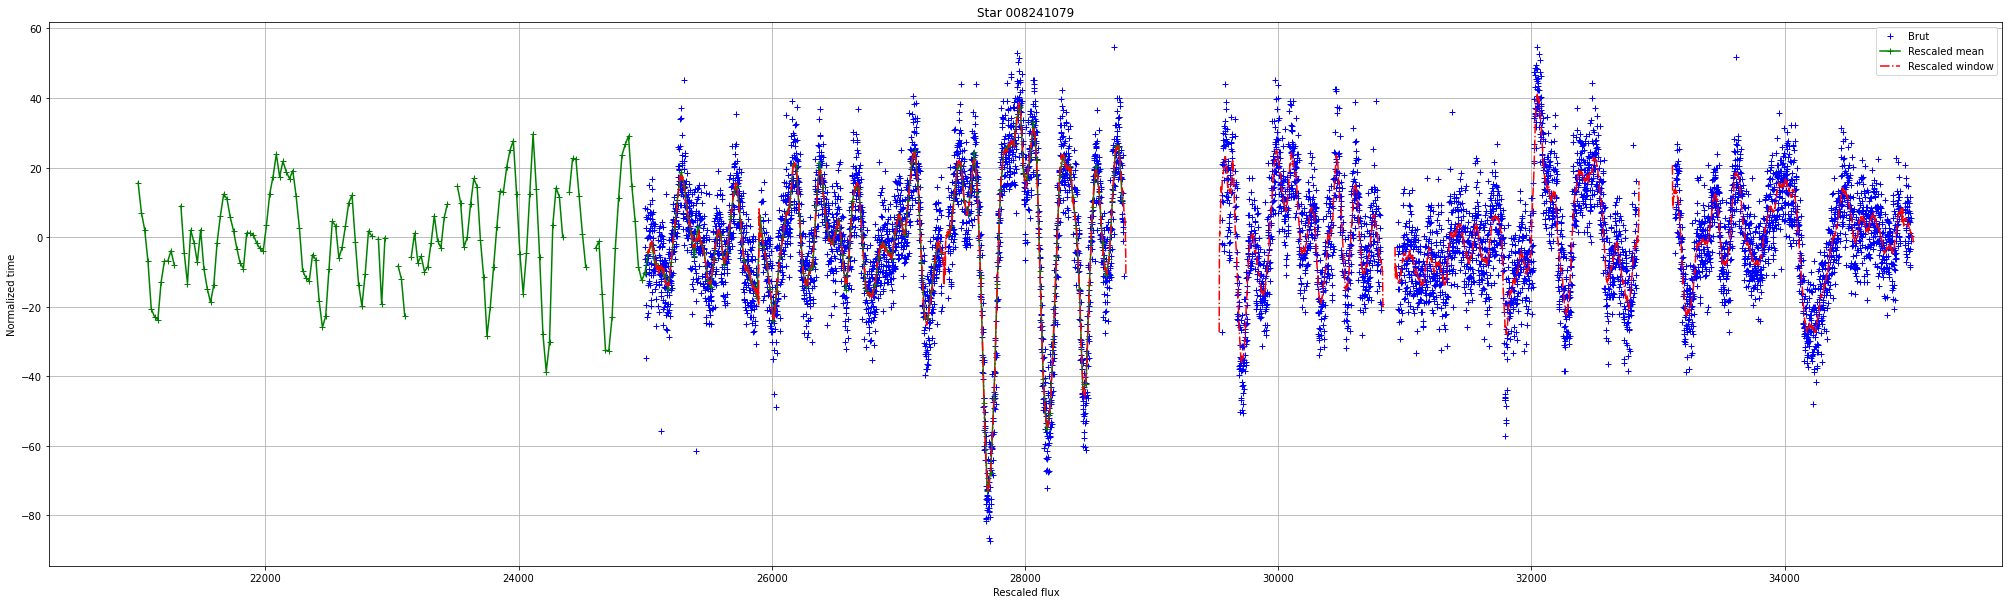

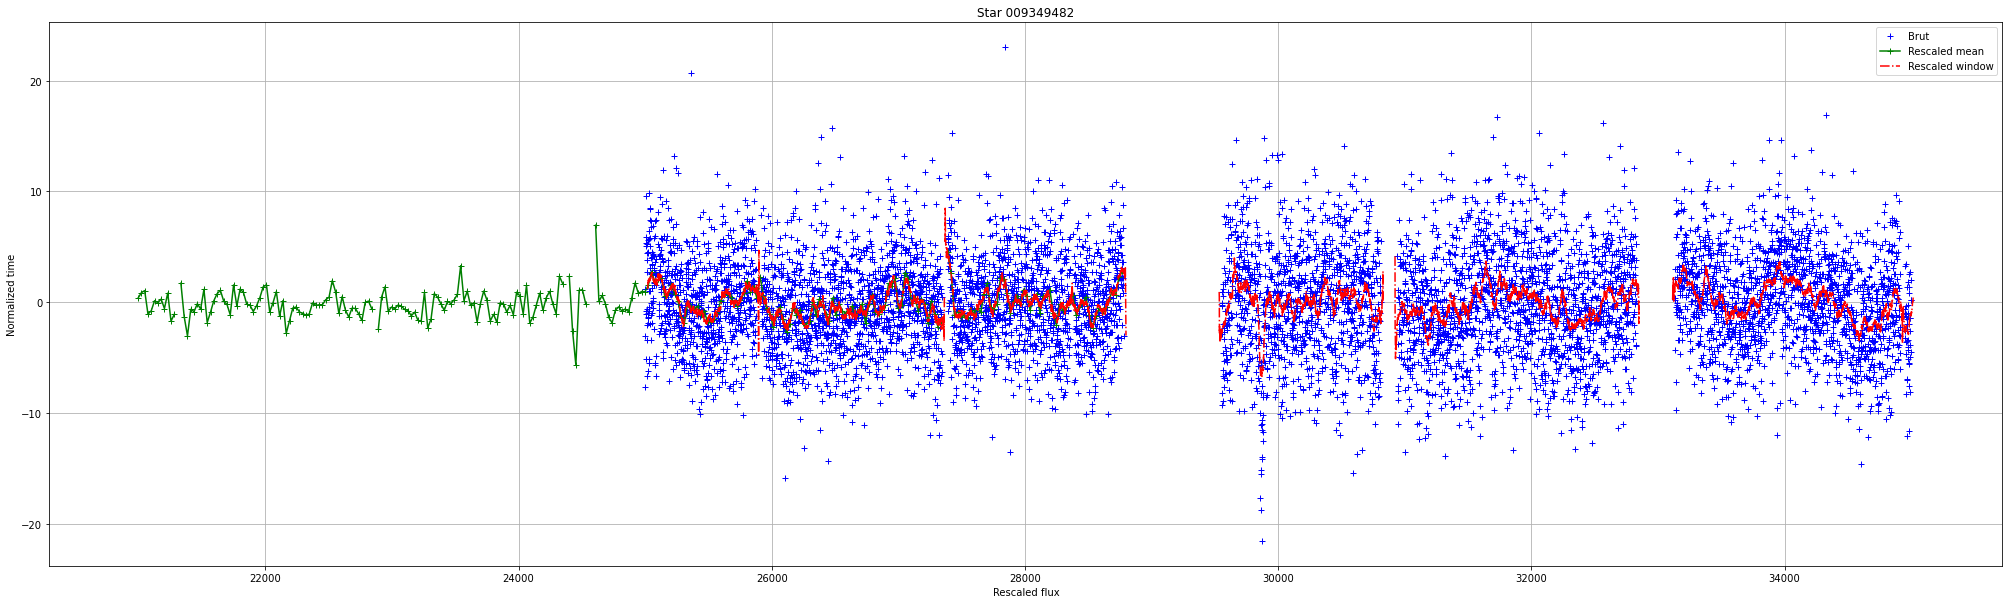

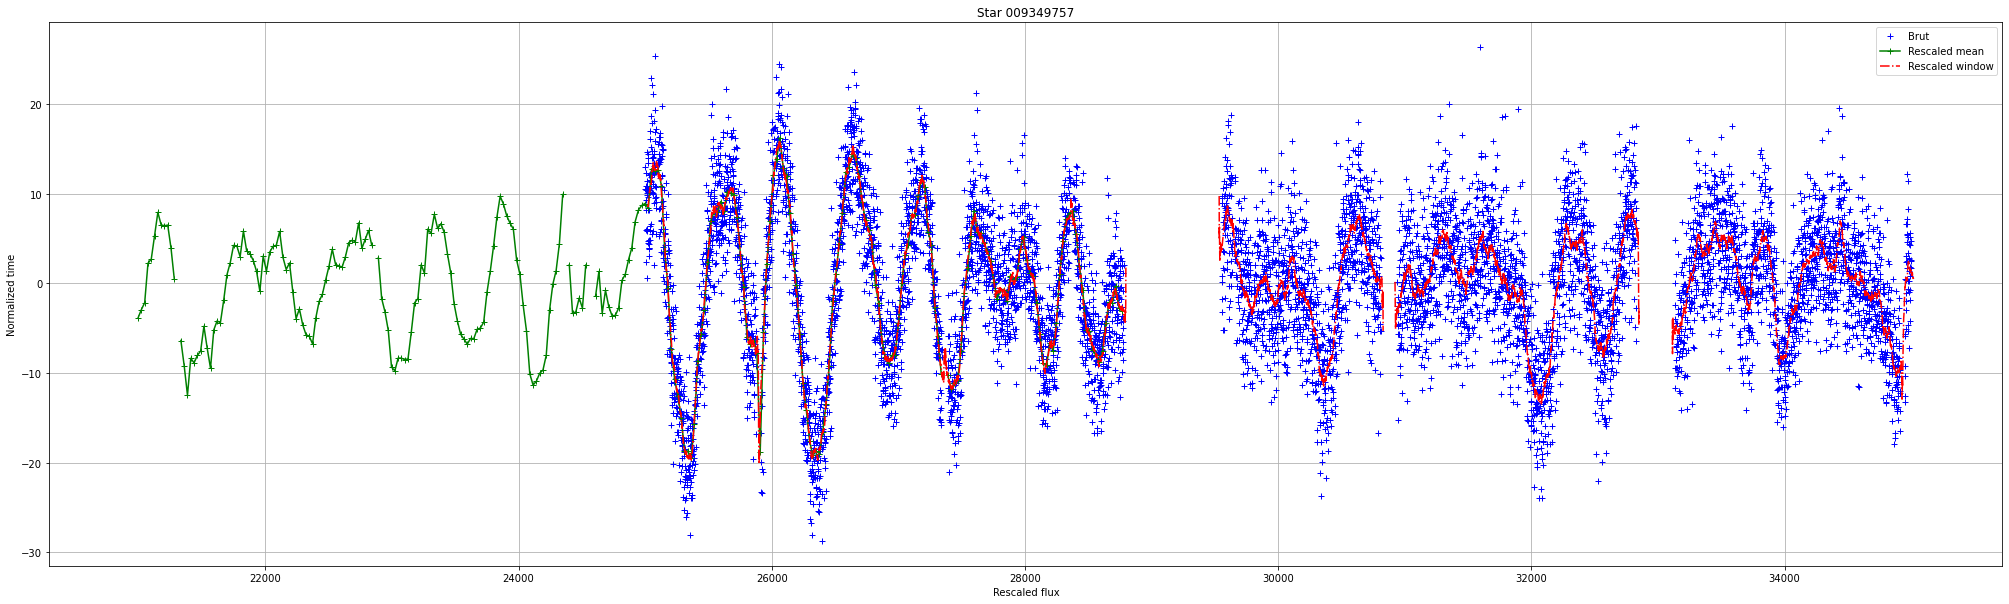

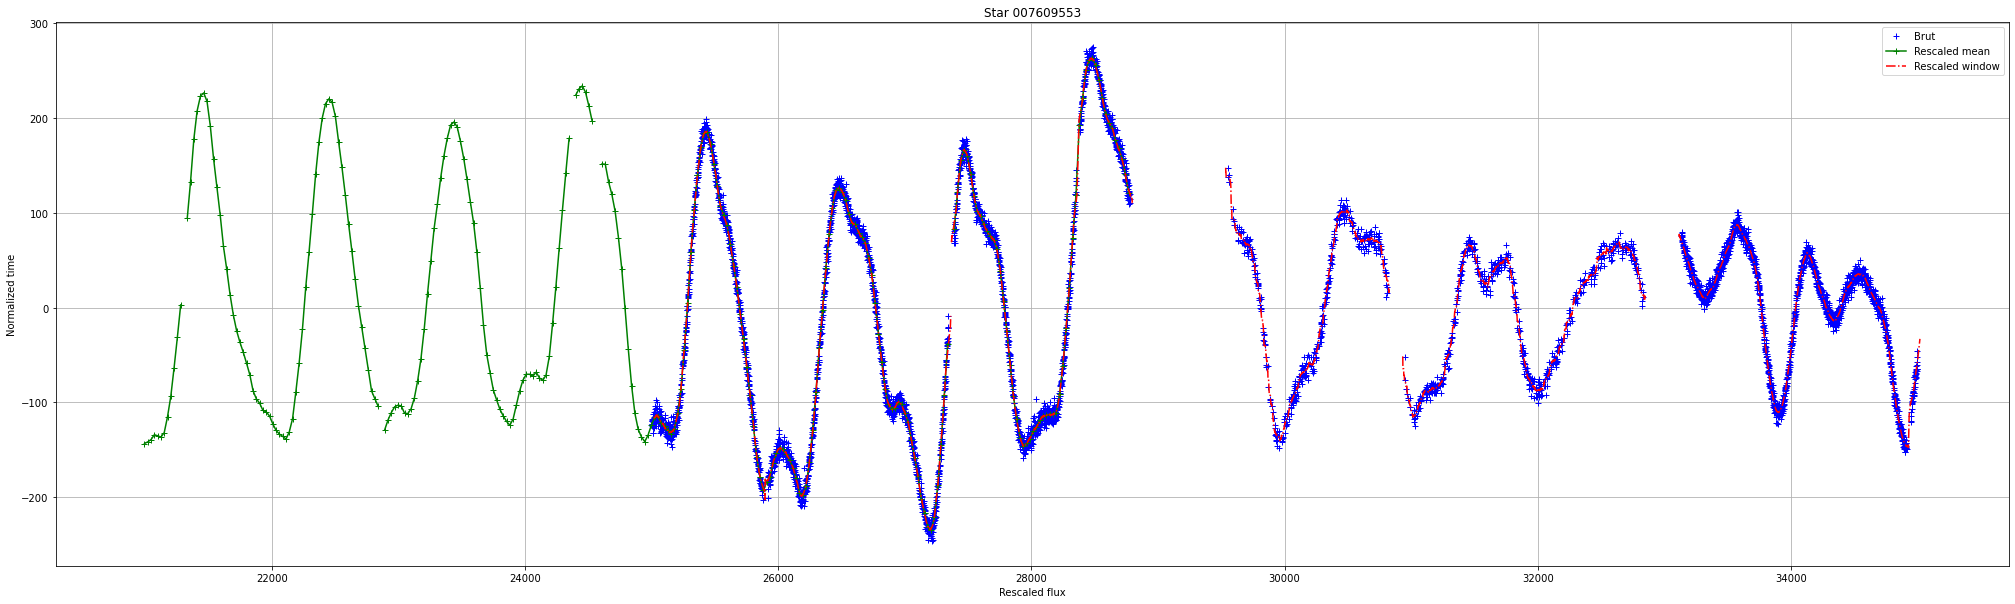

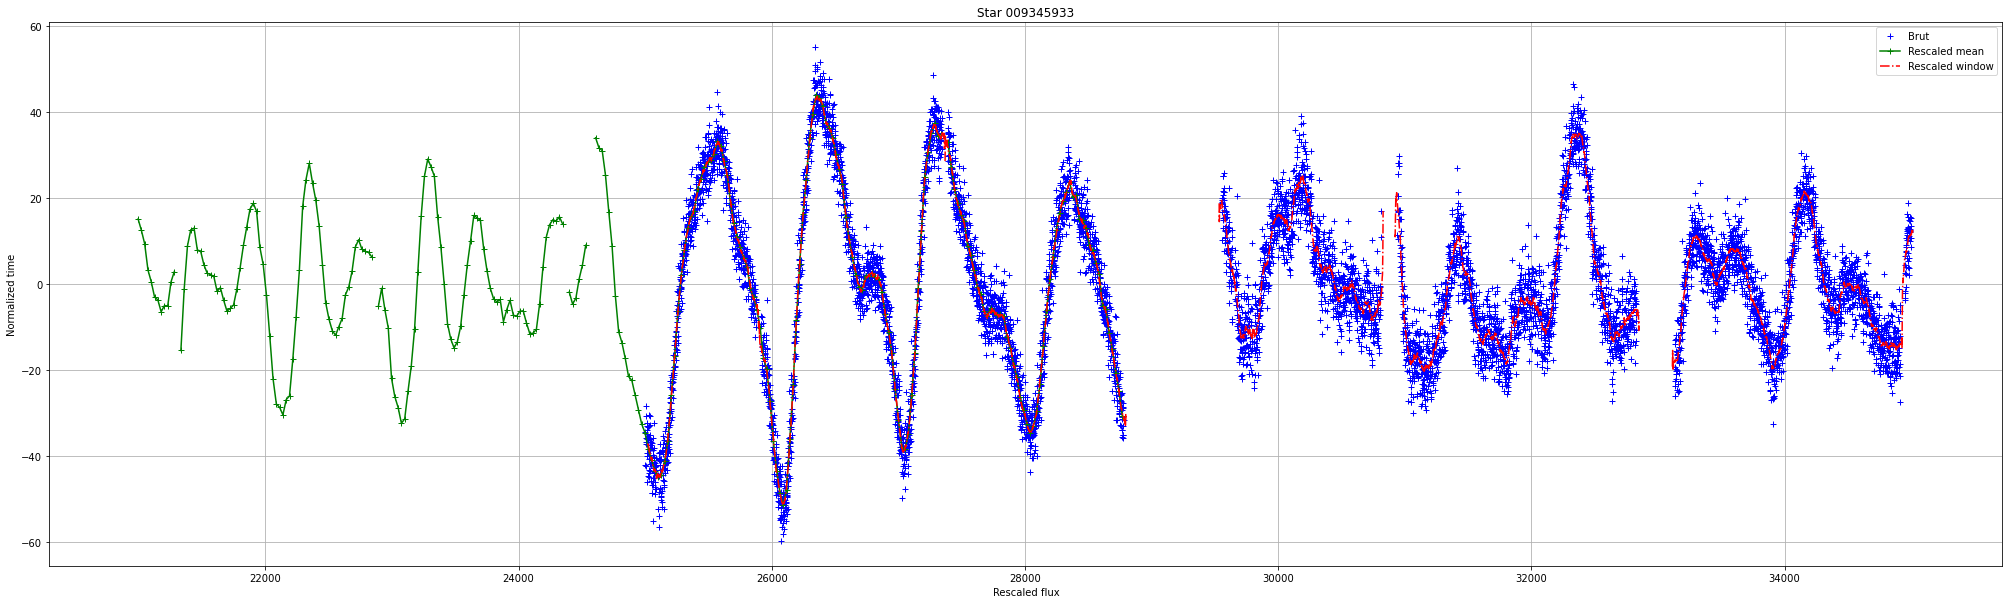

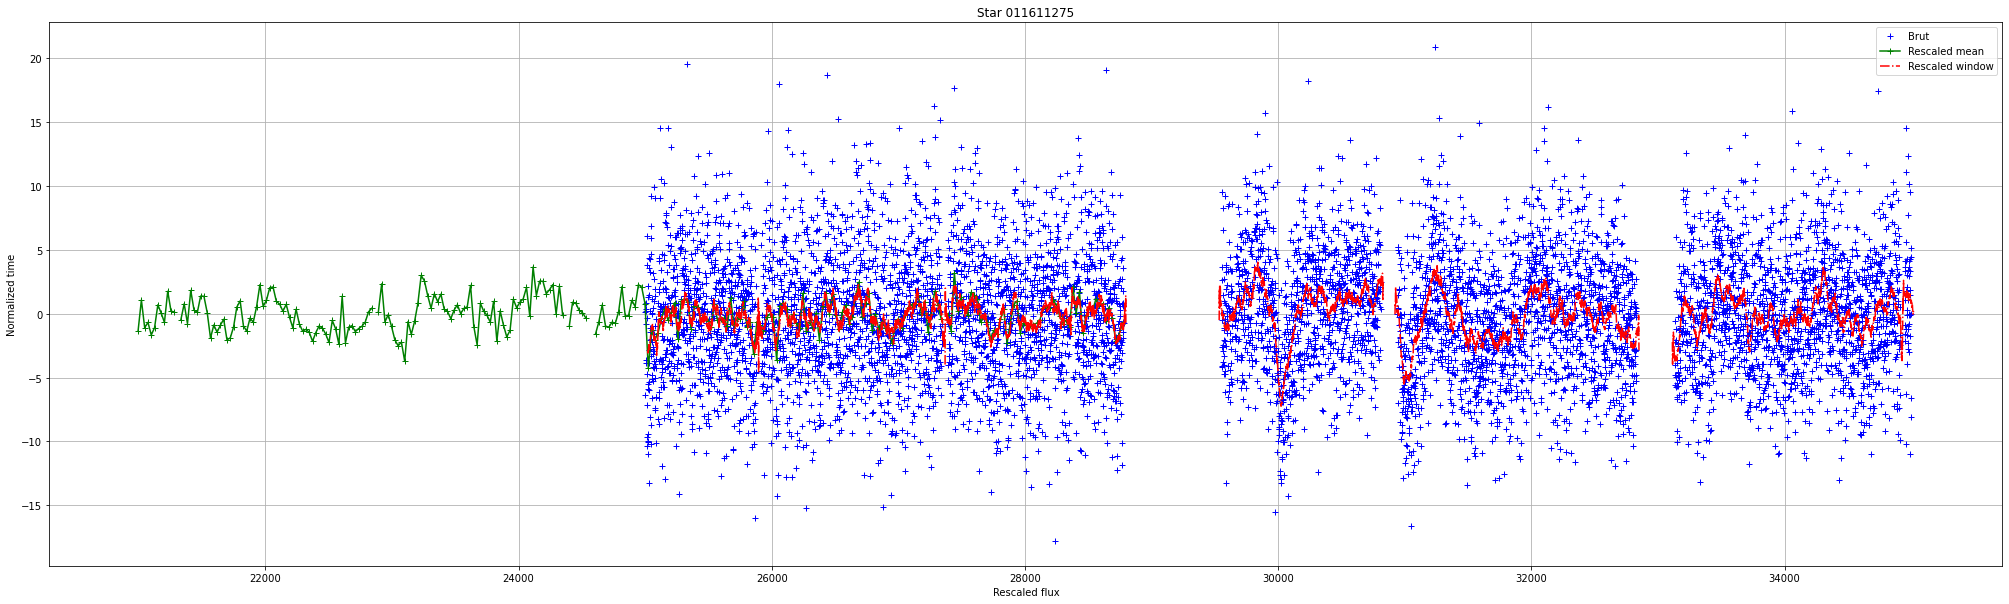

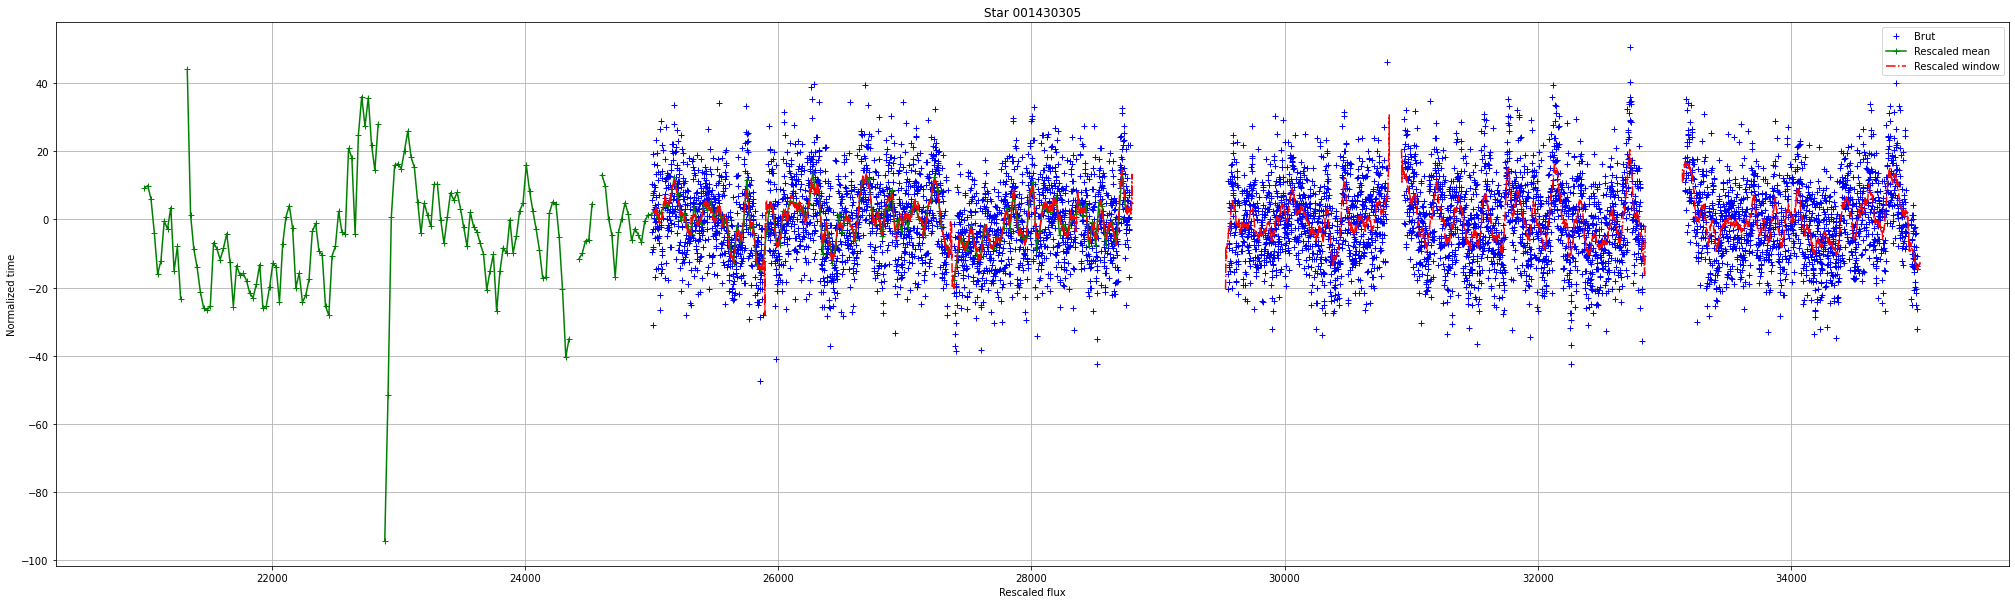

In [24]:
for i in tqdm(stars):
    name = i + "_rscl"
    plt.figure(figsize=(35, 10))
    plt.plot(df.index[25000:35000], df[name][25000:35000], "b+", label="Brut")
    plt.plot(
        df_mean[name + "_x"][807:1125],
        df_mean[name + "_y"][807:1125],
        "g-+",
        label="Rescaled mean",
    )
    plt.plot(
        df_slide[name + "_x"][25000:35000],
        df_slide[name + "_y"][25000:35000],
        "r-.",
        label="Rescaled window",
    )
    plt.legend()
    plt.title(f"Star {i}")
    plt.xlabel("Rescaled flux")
    plt.ylabel("Normalized time")
    plt.grid(True)

Seems pretty good don't you ? Let's zoom a little. Printing just 5,000 points.

  0%|          | 0/13 [00:00<?, ?it/s]

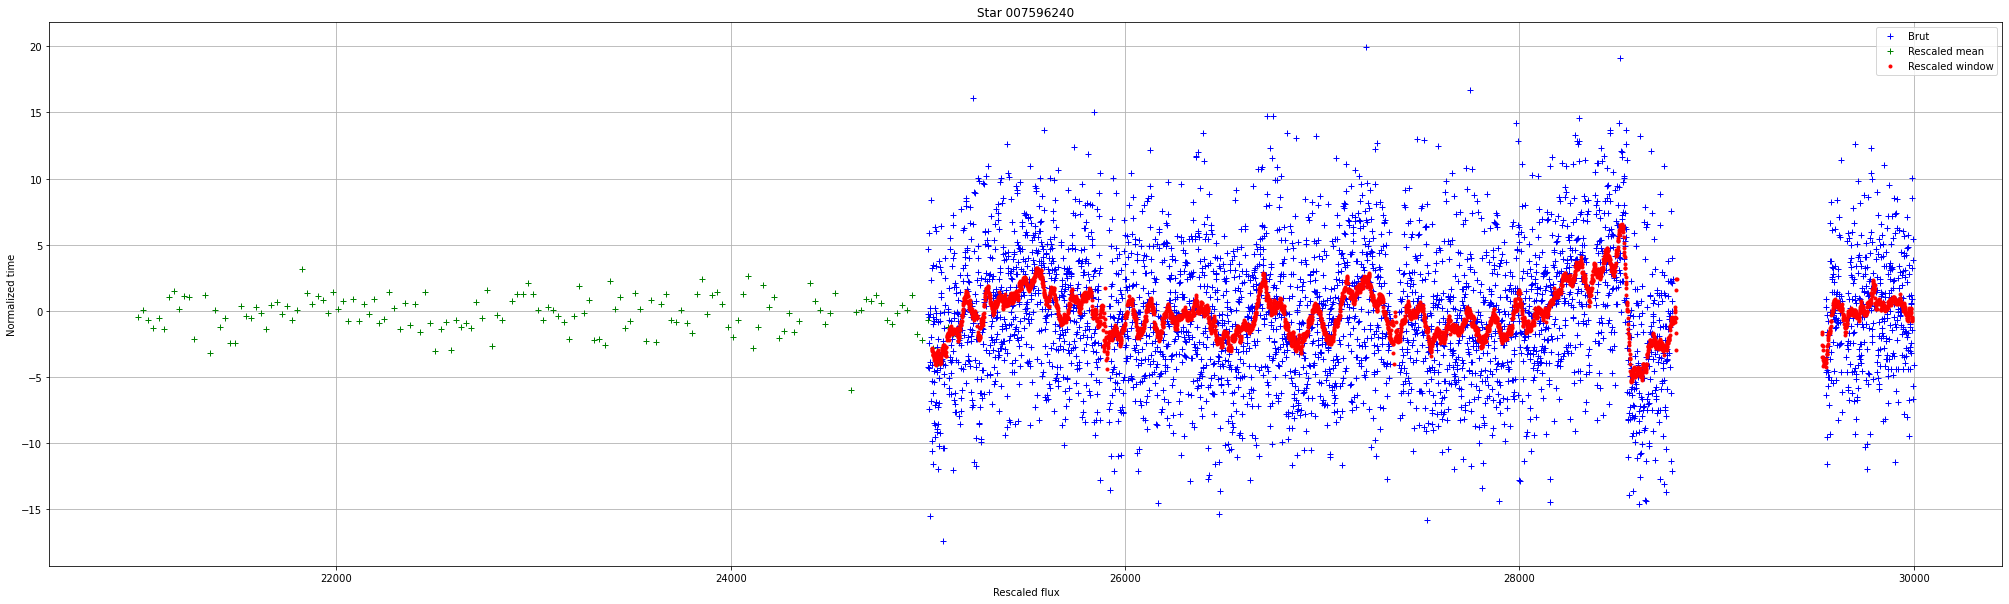

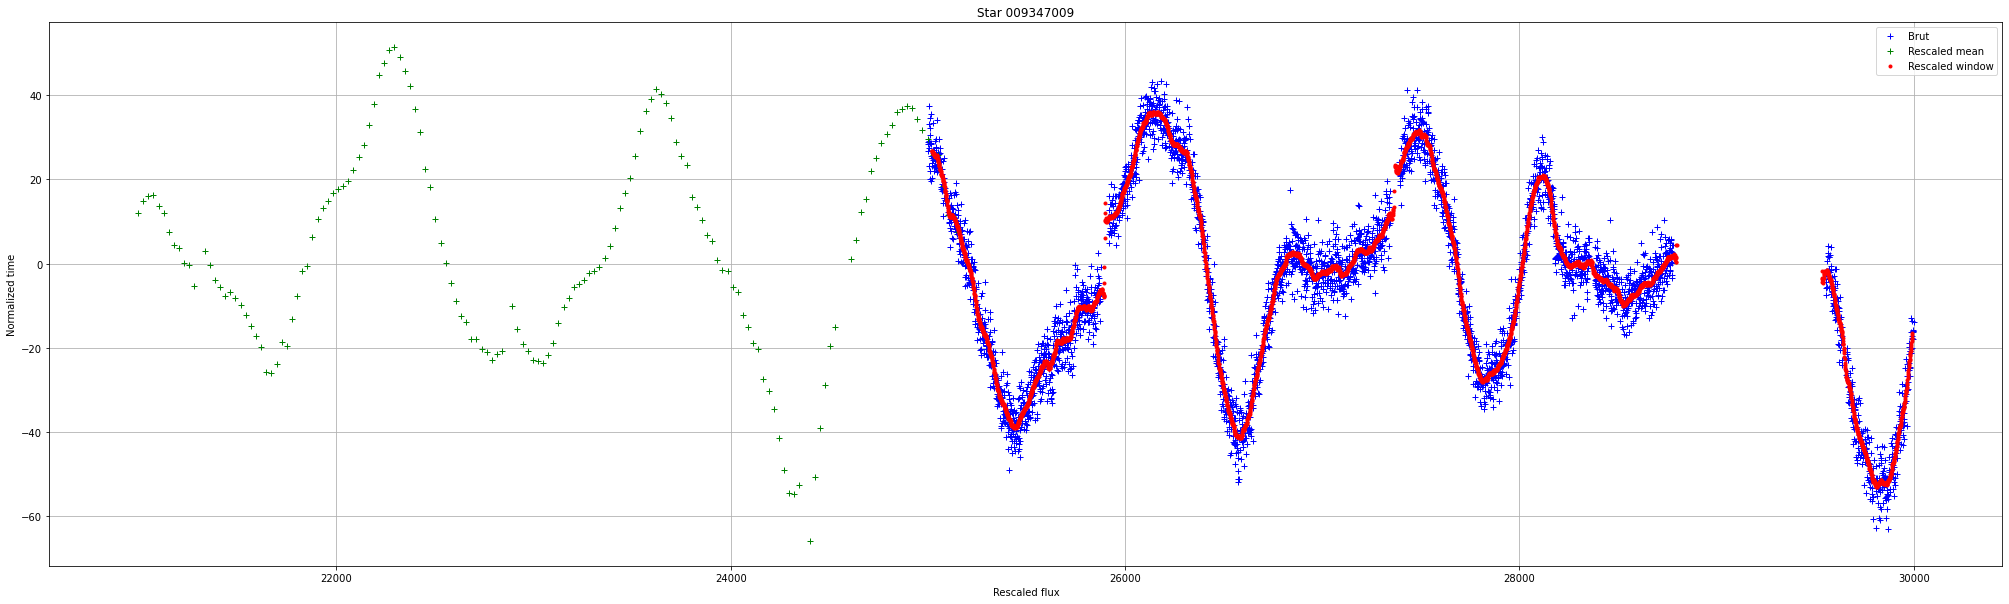

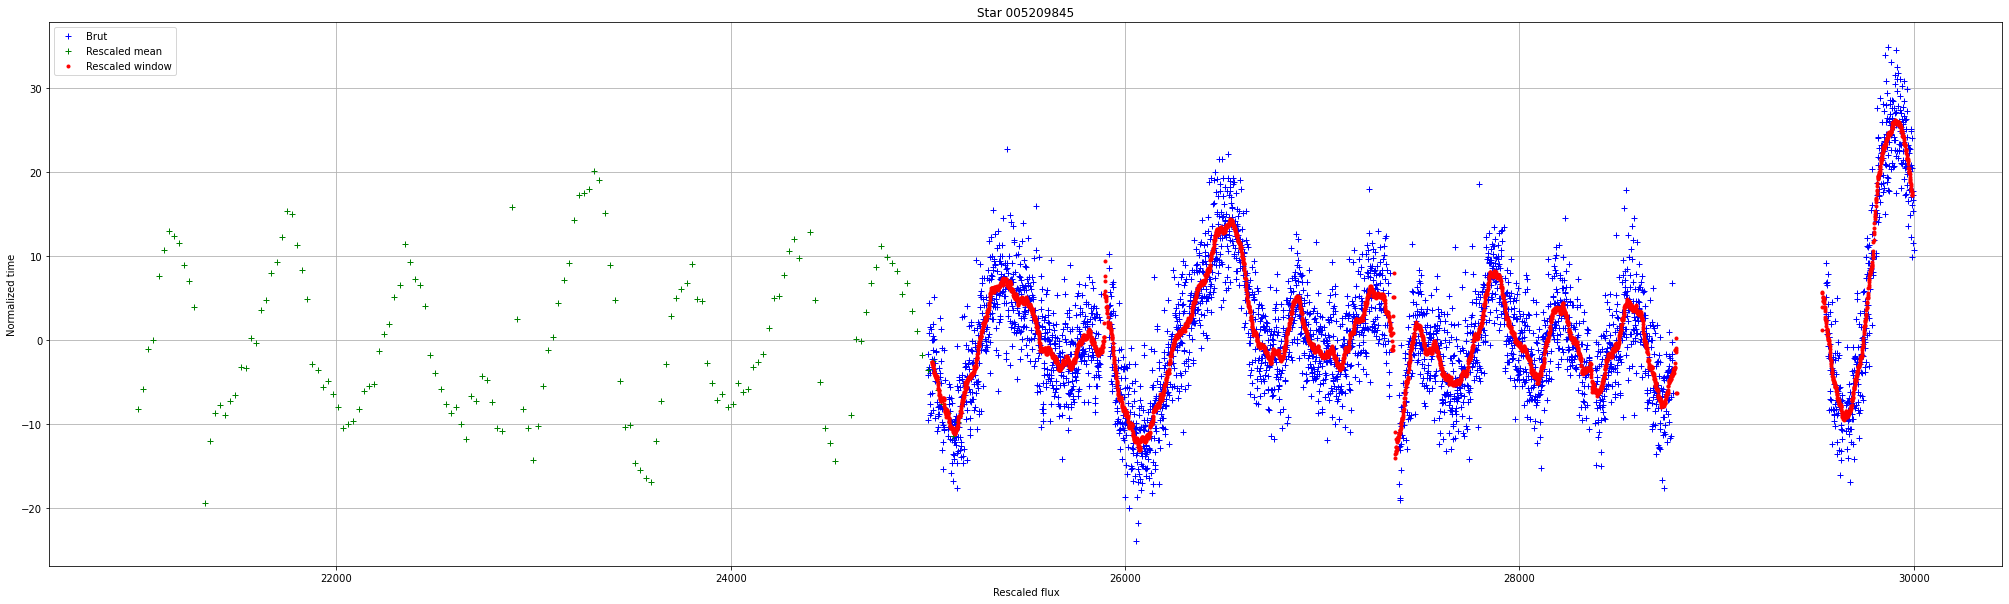

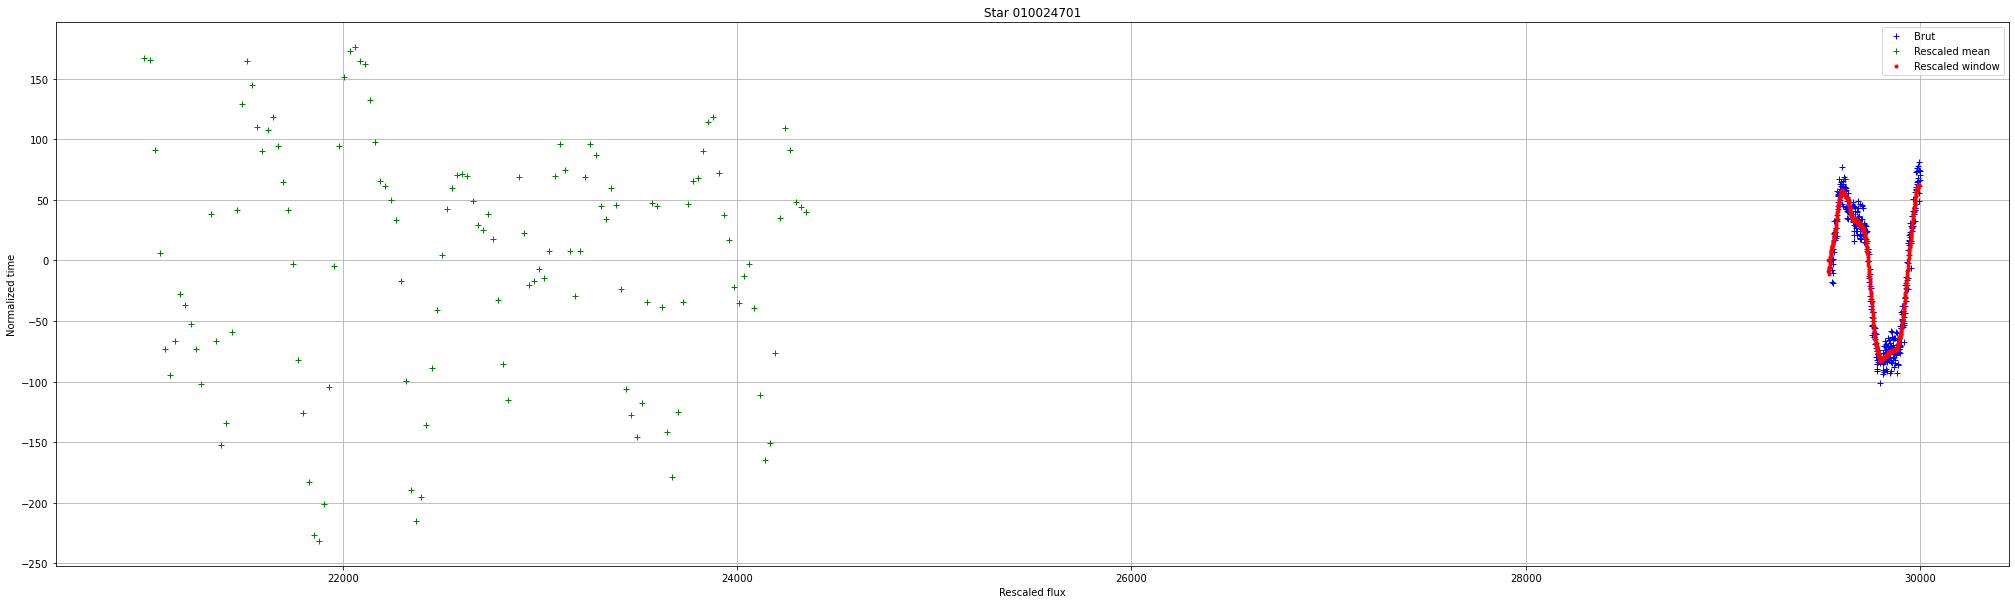

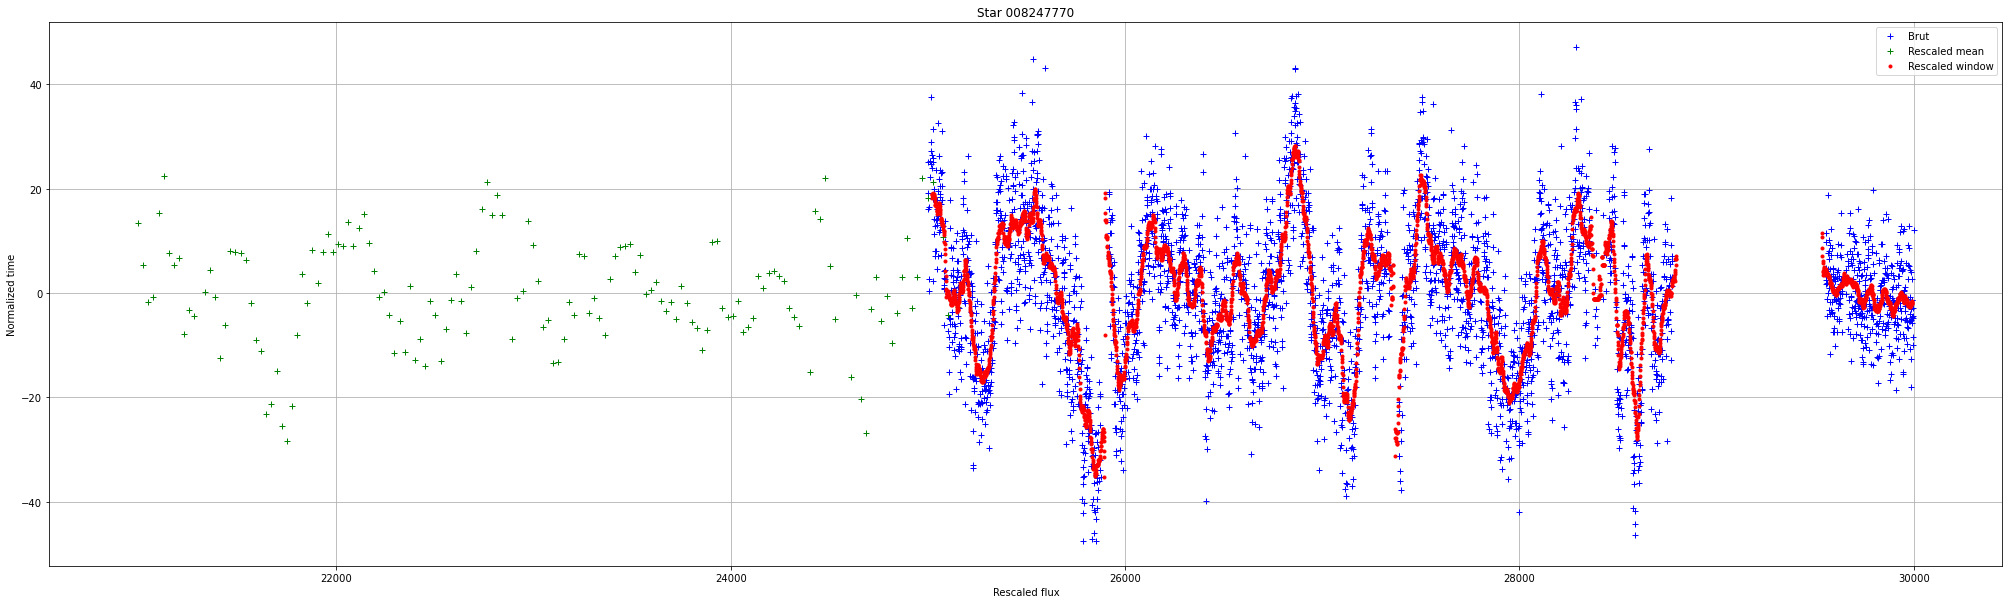

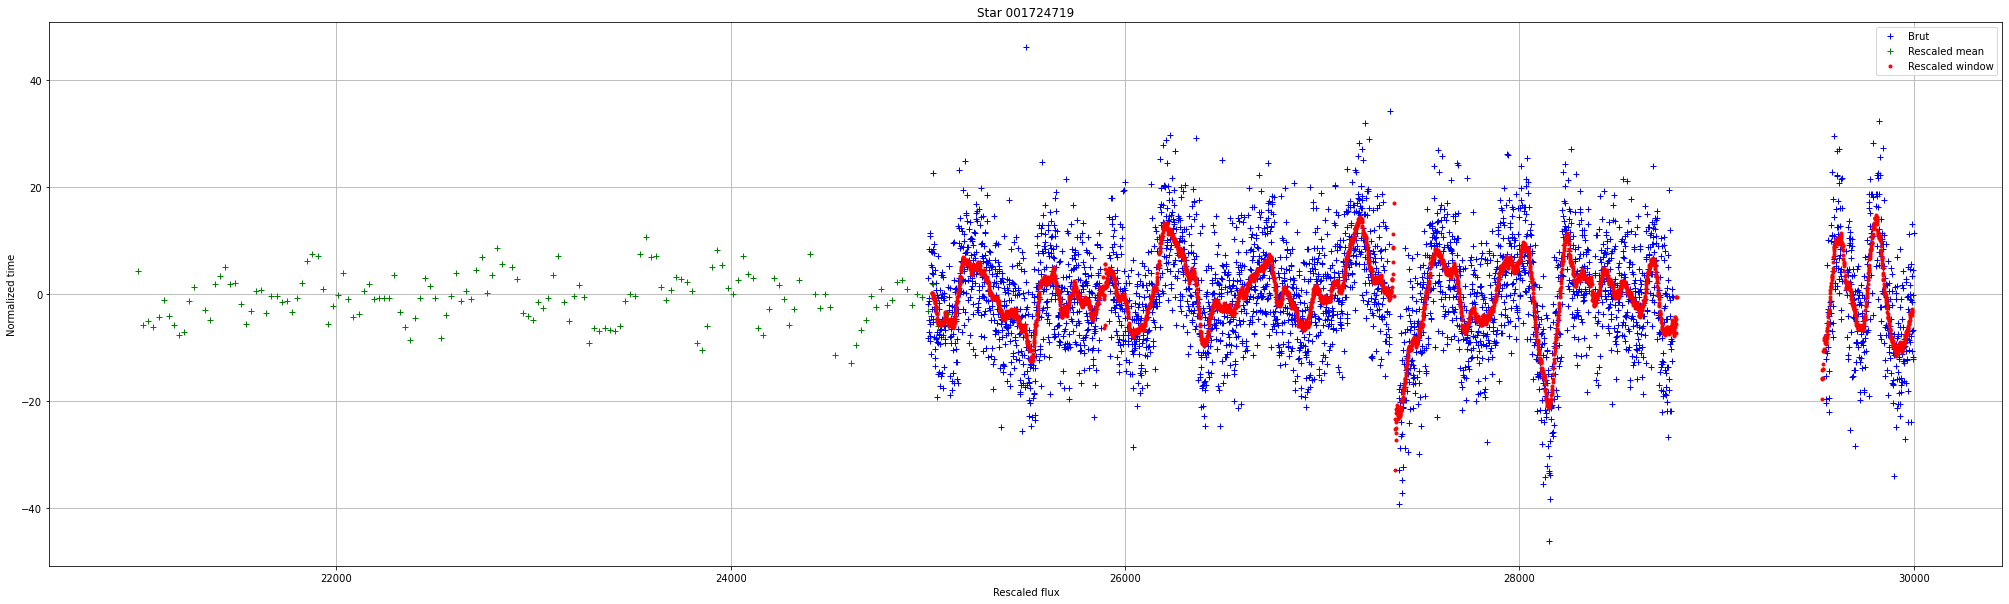

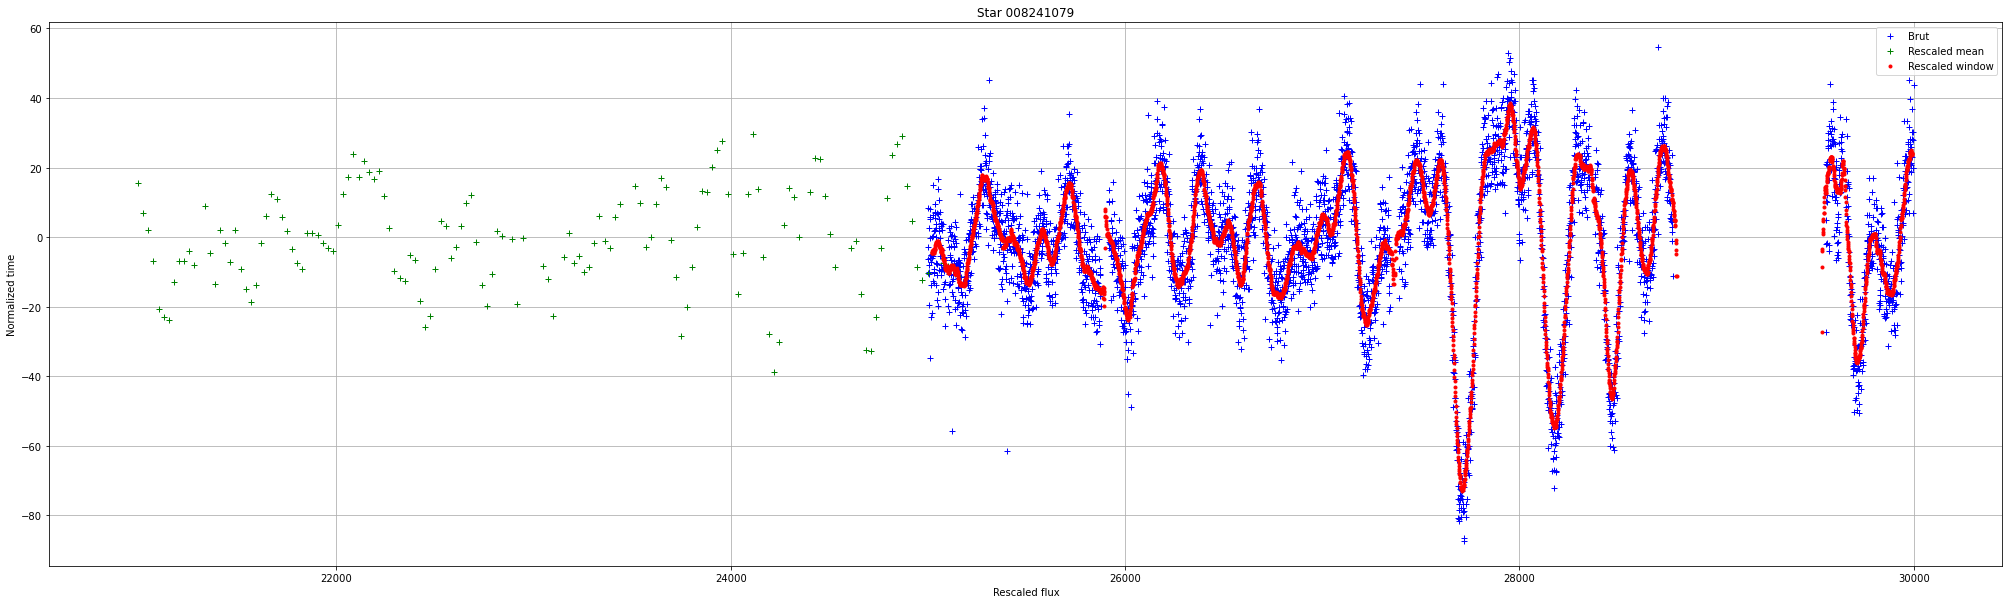

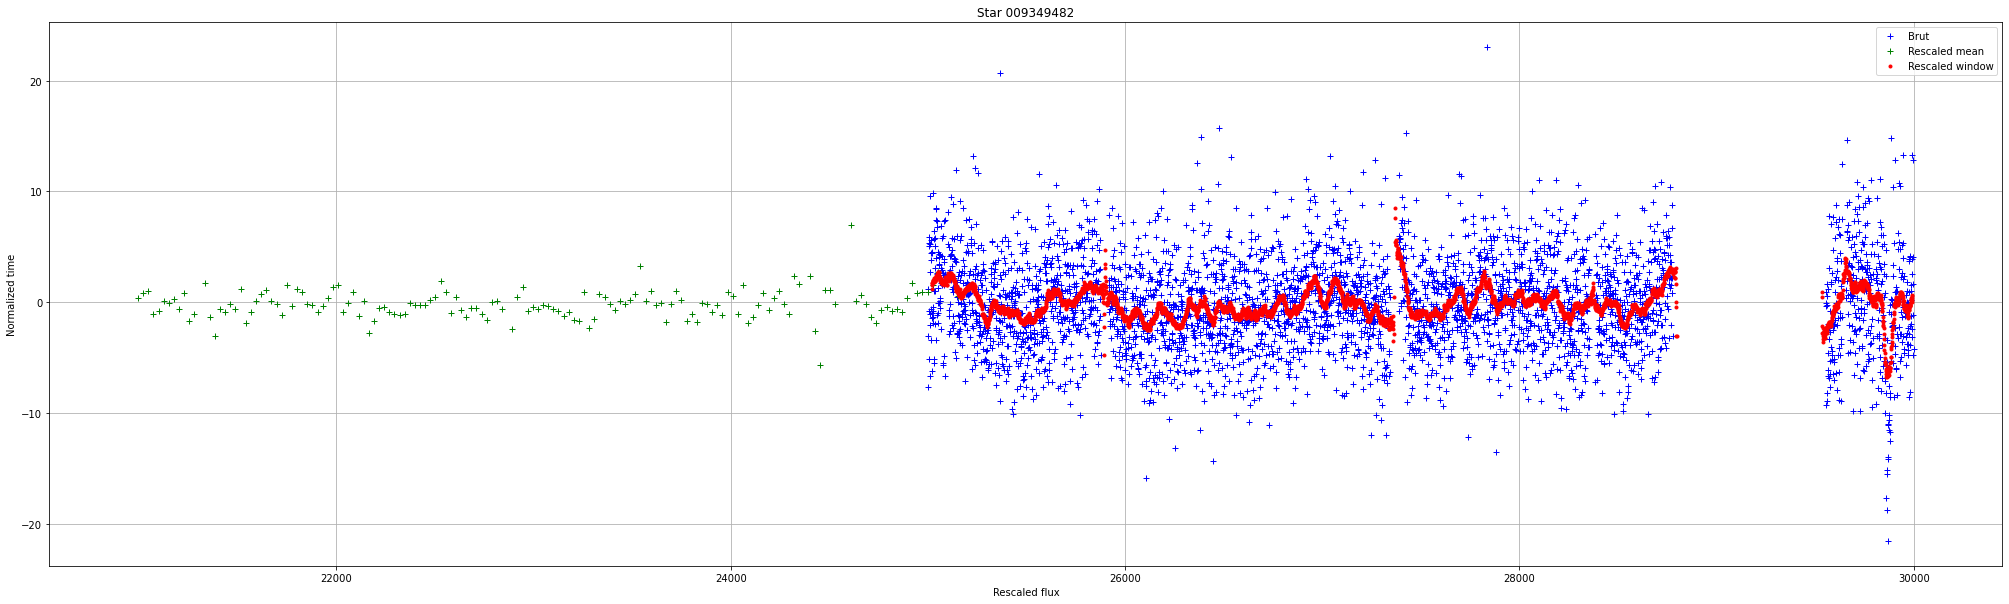

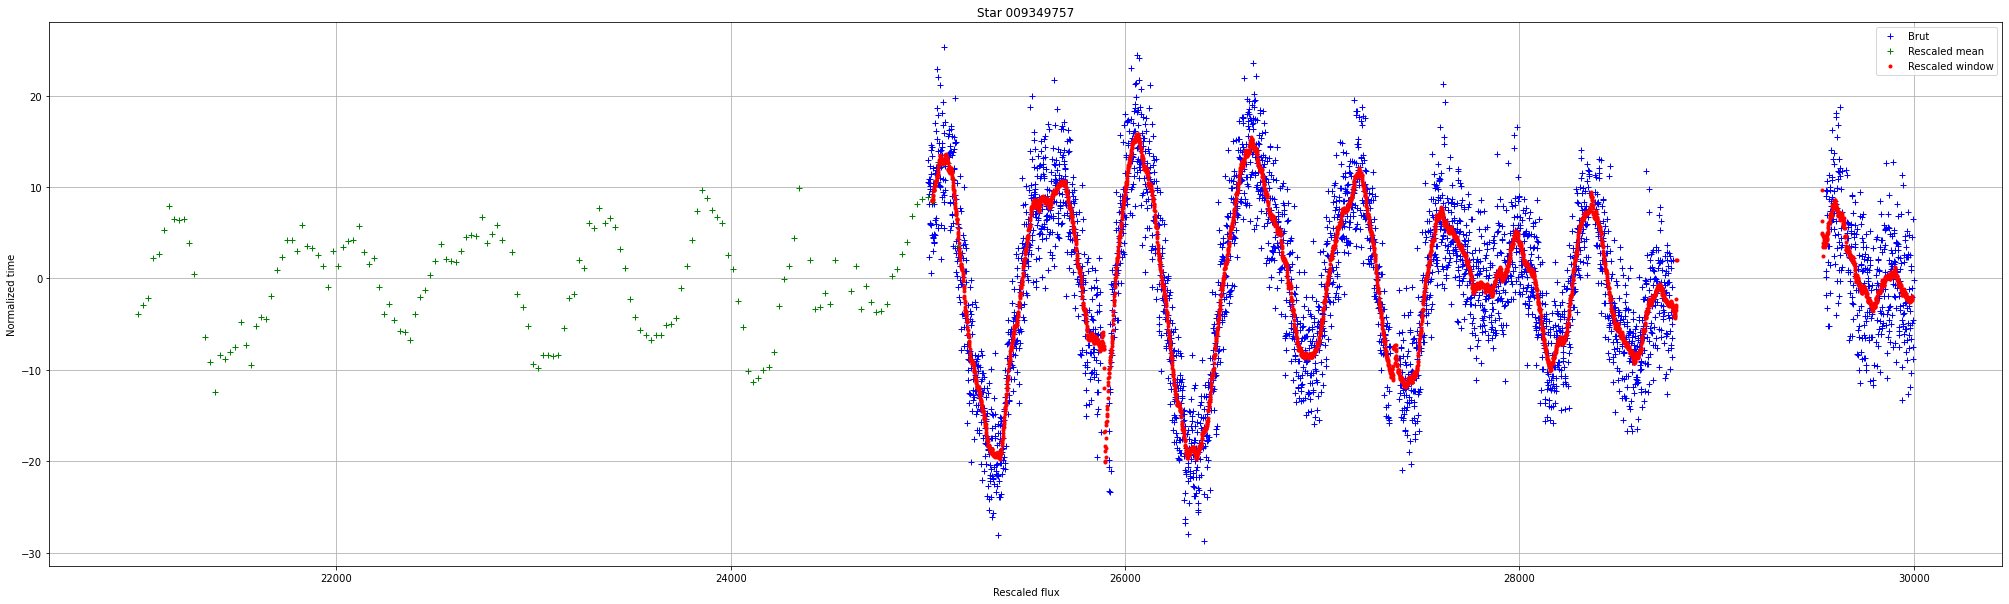

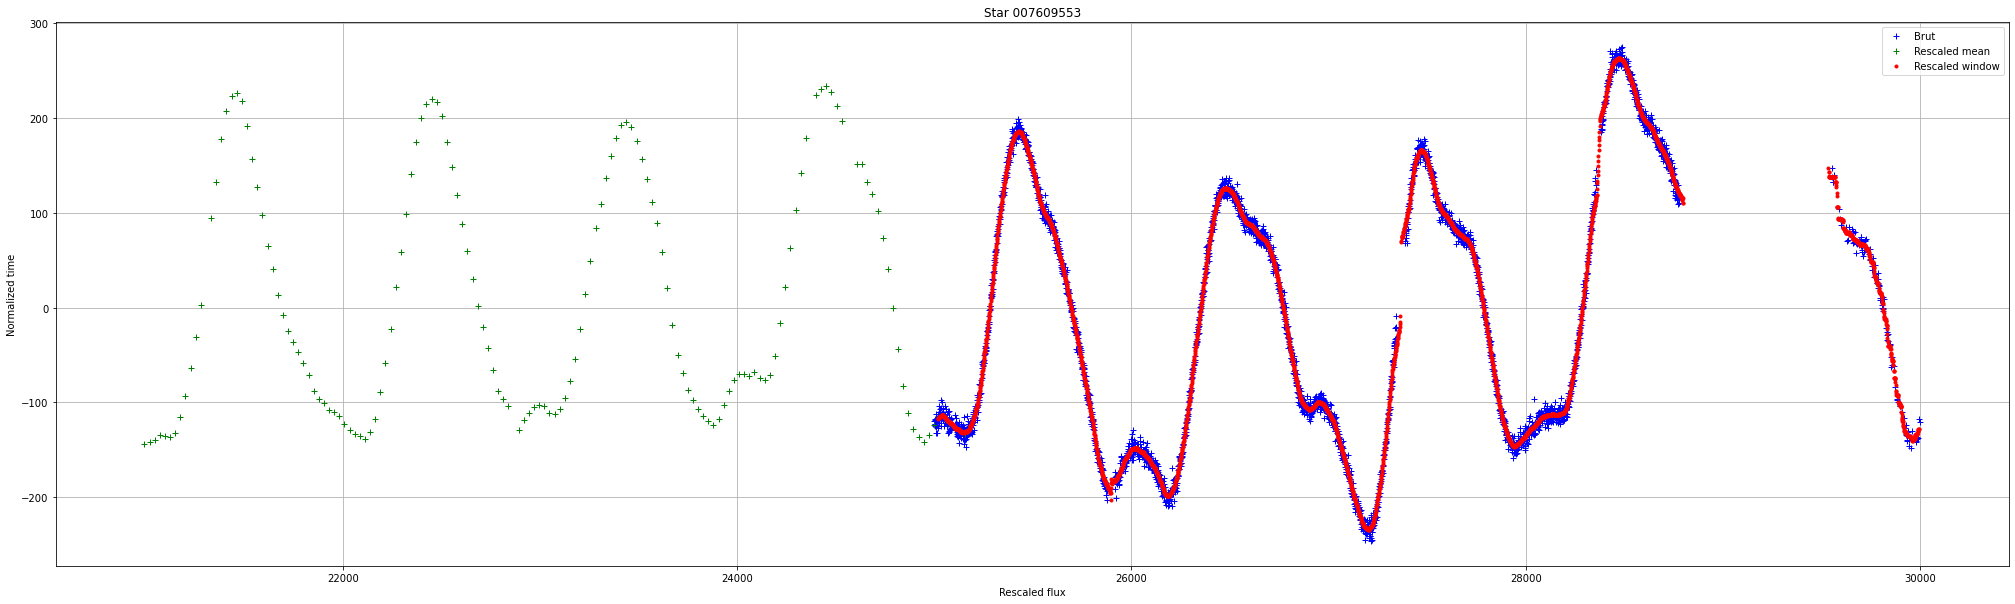

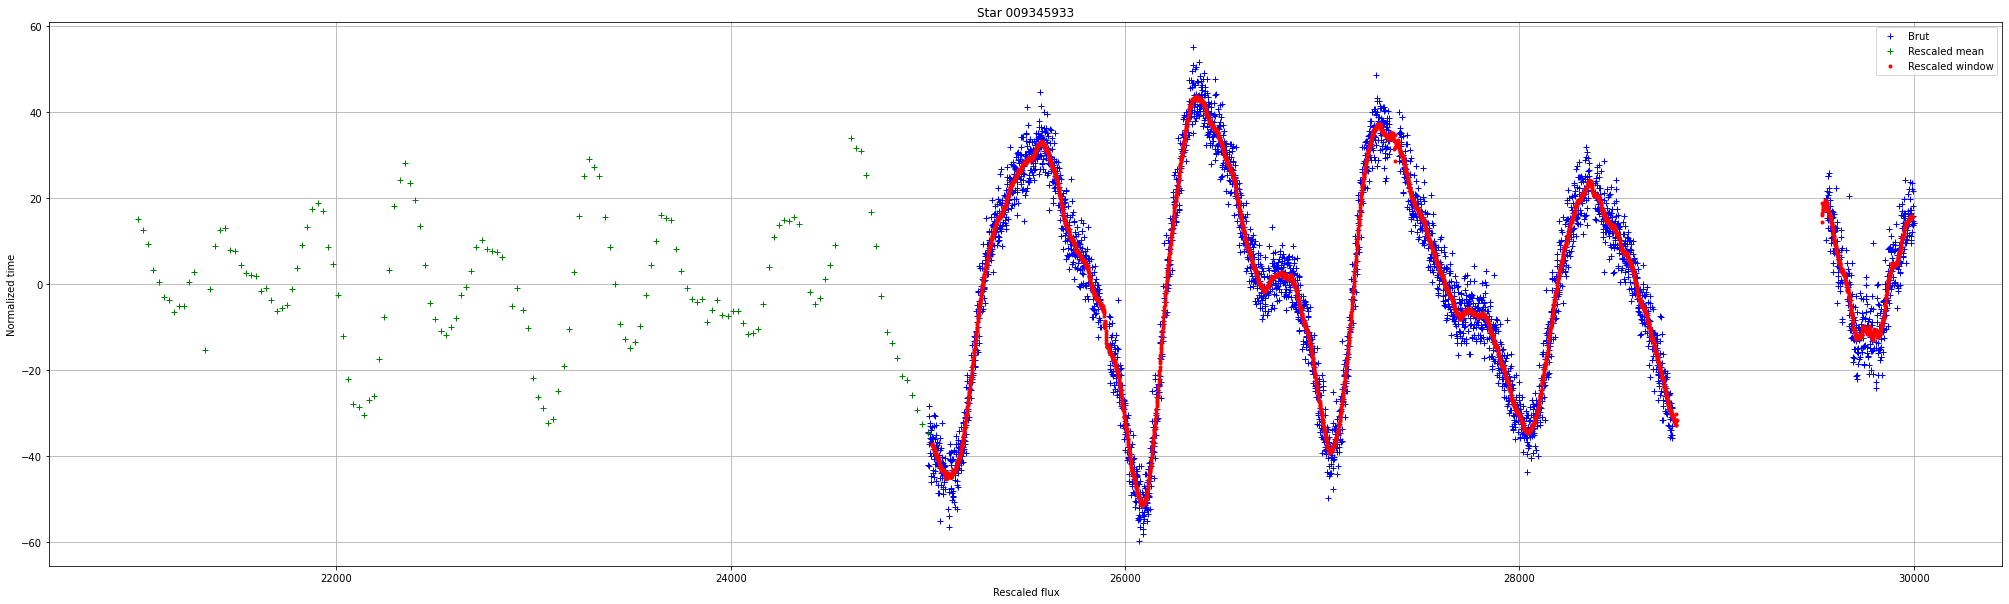

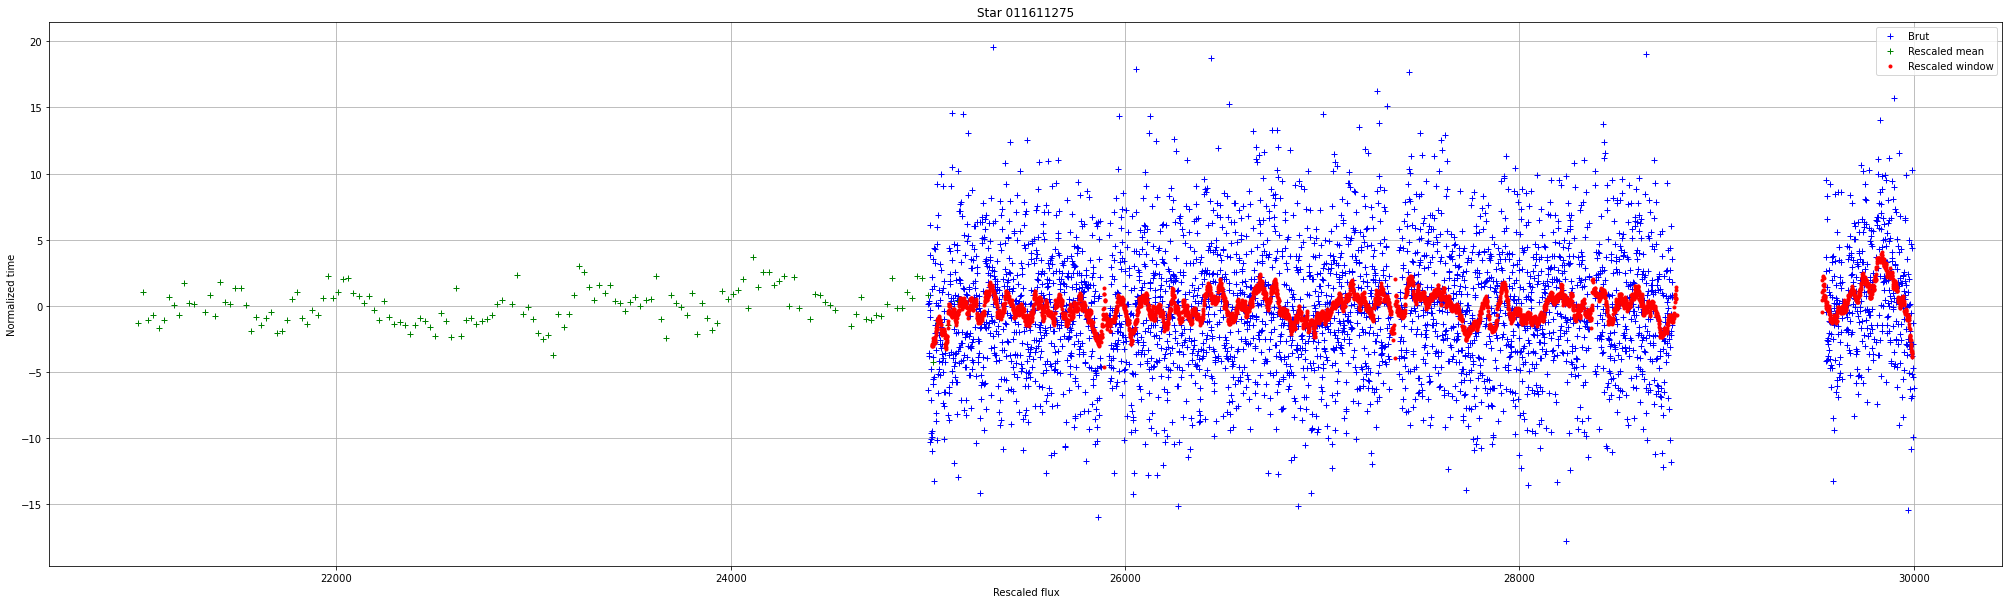

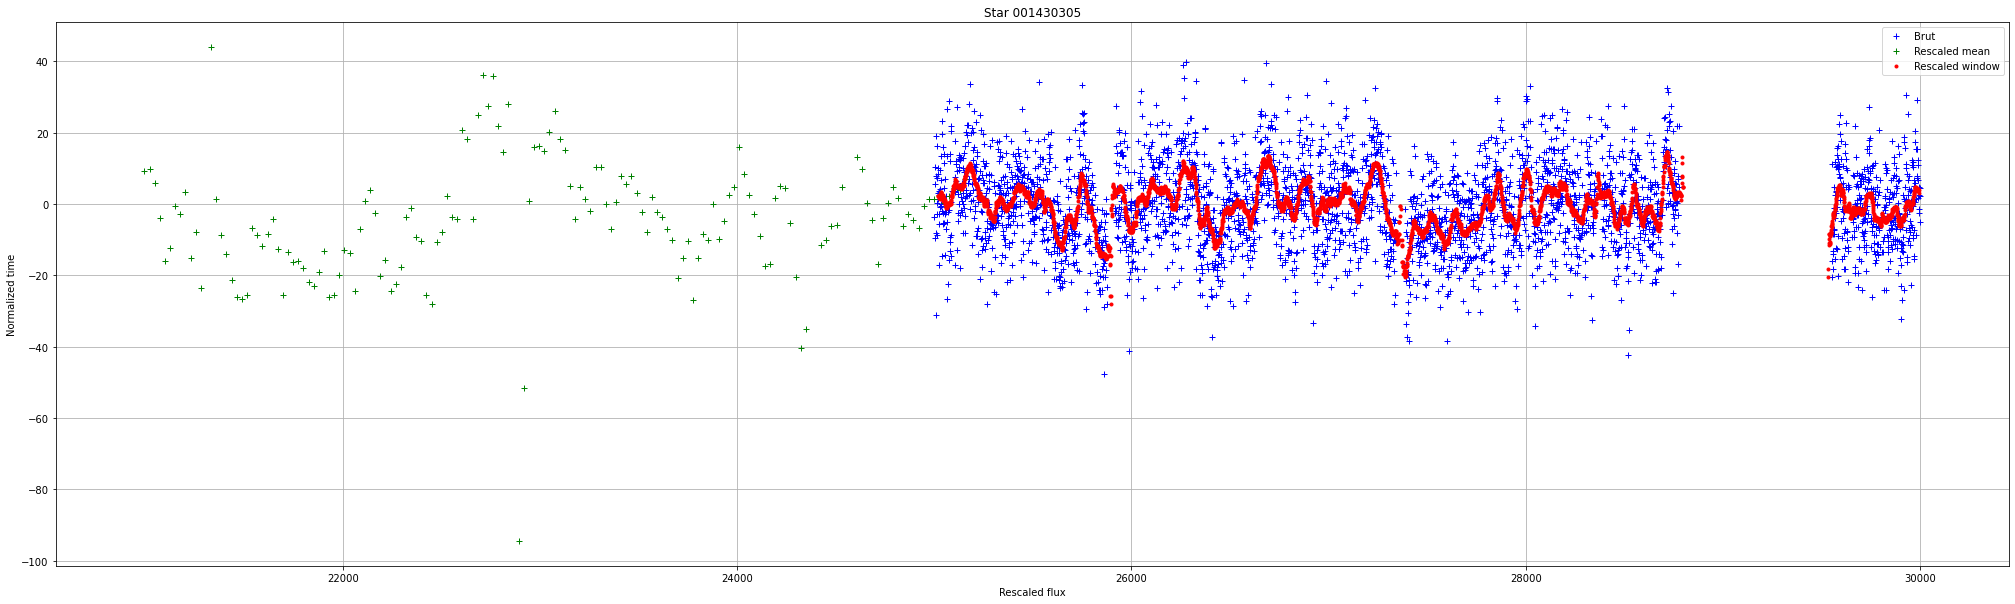

In [25]:
for i in tqdm(stars):
    name = i + "_rscl"
    plt.figure(figsize=(35, 10))
    plt.plot(df.index[25000:30000], df[name][25000:30000], "b+", label="Brut")
    plt.plot(
        df_mean[name + "_x"][807:968],
        df_mean[name + "_y"][807:968],
        "g+",
        label="Rescaled mean",
    )
    plt.plot(
        df_slide[name + "_x"][25000:29975],
        df_slide[name + "_y"][25000:29975],
        "r.",
        label="Rescaled window",
    )
    plt.legend()
    plt.title("Star " + i)
    plt.xlabel("Rescaled flux")
    plt.ylabel("Normalized time")
    plt.grid(True)

Here we see that all the data cannot be reduced with the same parameters. Certain curve can be more smooth.

If we look closer, the star 010024701 has just few points. We need to rescale this star.

  0%|          | 0/1 [00:00<?, ?it/s]

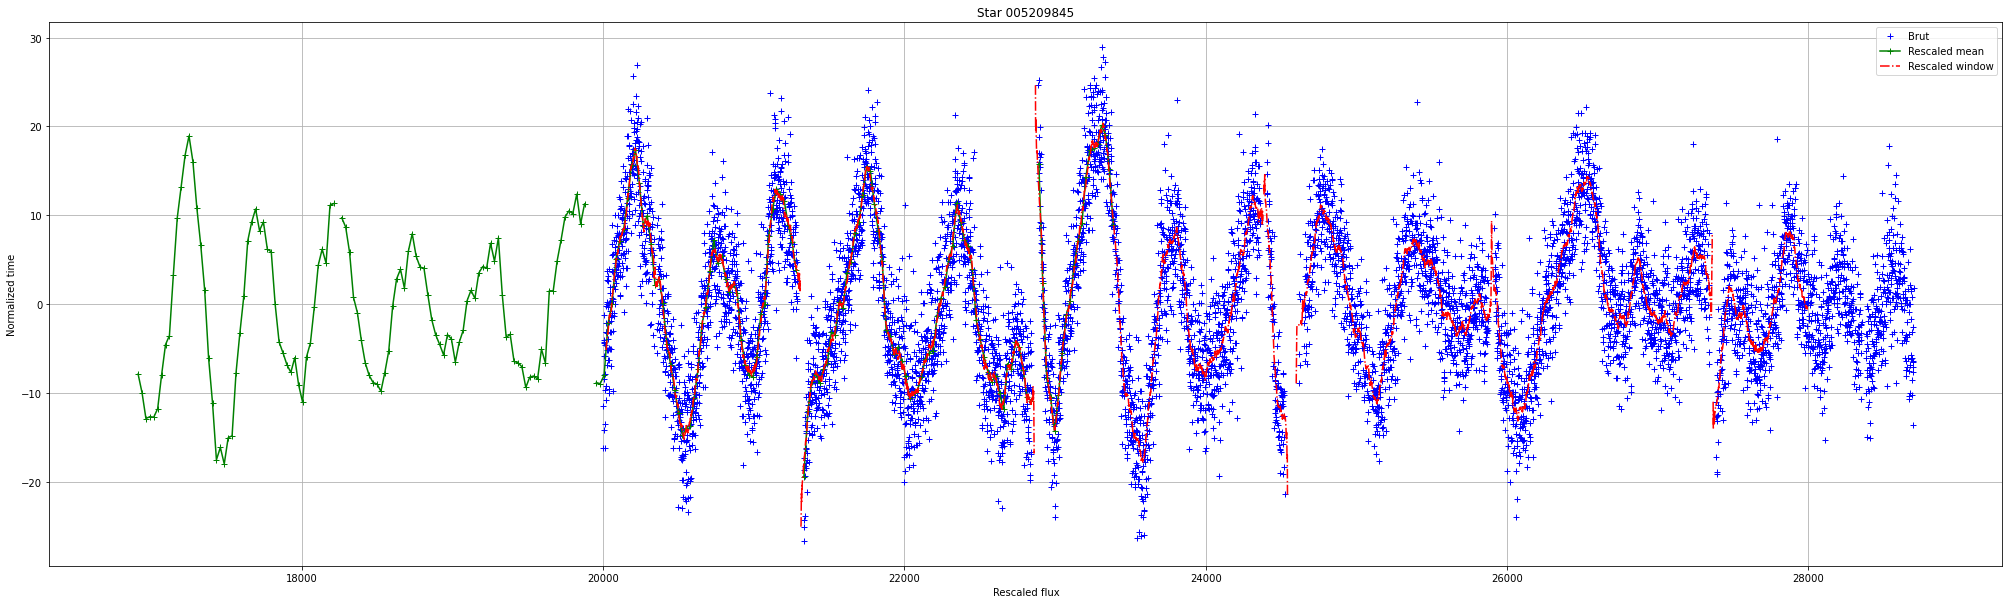

In [26]:
for i in tqdm(stars[2:3]):
    name = i + "_rscl"
    plt.figure(figsize=(35, 10))
    plt.plot(df.index[20000:28700], df[name][20000:28700], "b+", label="Brut")
    plt.plot(
        df_mean[name + "_x"][650:900],
        df_mean[name + "_y"][650:900],
        "g-+",
        label="Rescaled mean",
    )
    plt.plot(
        df_slide[name + "_x"][20000:27975],
        df_slide[name + "_y"][20000:27975],
        "r-.",
        label="Rescaled window",
    )
    plt.legend()
    plt.title(f"Star {i}")
    plt.xlabel("Rescaled flux")
    plt.ylabel("Normalized time")
    plt.grid(True)
    plt.savefig("ligthcurve_" + i + ".jpg")

# Forecasting with Machine Learning

We need two forecast in this data, if you look with attention you'll see micro holes and big holes.

In [27]:
df_model = df_mean.copy()
df_model2 = df_slide.copy()
# df_model[stars[9]+"_rscl"].fillna((0), inplace=True)

df_model

x_train = df_model[stars[2] + "_rscl_y"][:27000].dropna()

x_train.shape

# <h3><u><i>Rescaled index</i></u></h3>

df.index = pd.date_range("2009-03-07", periods=len(df.index), freq="h")

df.index

DatetimeIndex(['2009-03-07 00:00:00', '2009-03-07 01:00:00',
               '2009-03-07 02:00:00', '2009-03-07 03:00:00',
               '2009-03-07 04:00:00', '2009-03-07 05:00:00',
               '2009-03-07 06:00:00', '2009-03-07 07:00:00',
               '2009-03-07 08:00:00', '2009-03-07 09:00:00',
               ...
               '2017-04-29 17:00:00', '2017-04-29 18:00:00',
               '2017-04-29 19:00:00', '2017-04-29 20:00:00',
               '2017-04-29 21:00:00', '2017-04-29 22:00:00',
               '2017-04-29 23:00:00', '2017-04-30 00:00:00',
               '2017-04-30 01:00:00', '2017-04-30 02:00:00'],
              dtype='datetime64[ns]', length=71427, freq='H')

# Data preparation

convert an array of values into a dataset matrix

In [29]:
def create_dataset(values, look_back=1):
    """
    Function to prepare a list of (x, y) data points to data for time series learning
    @param values: (list) list of values
    @param look_back: (int) number of values for the x list [x1, x2, x3, ... , xn] default 1
    @return _x: x values for the time series
    @return _y: y values for the time series
    """
    # set empty lists
    _x, _y = [], []
    for i in range(len(values) - look_back - 1):
        a = values[i : (i + look_back)]  # stack a list of values
        _x.append(a)  # set x
        _y.append(values[i + look_back])  # set y
    return np.array(_x), np.array(_y)

fix random seed for reproducibility

In [30]:
np.random.seed(42)

num = 2
values = df_model[stars[num] + "_rscl_y"].values

normalize the dataset

In [31]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(values[~np.isnan(values)].reshape(-1, 1))

split into train and test sets

In [32]:
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train, test = dataset[:train_size], dataset[train_size:]

reshape into X=t and Y=t+1

In [33]:
look_back = 20
train_x, train_y = create_dataset(train, look_back)
test_x, test_y = create_dataset(test, look_back)

reshape input to be [samples, time steps, features]

In [34]:
train_x = np.reshape(train_x, (train_x.shape[0], train_x.shape[1], 1))
test_x = np.reshape(test_x, (test_x.shape[0], test_x.shape[1], 1))

# Functions to generate DL models and plot

In [35]:
def metrics_time_series(y_true, y_pred):
    """
    Compute the MAE and MSE metrics from sklearn.metrics
    @param y_true: (list) list of the true values
    @param y_pred: (list) list of predicted values
    @return mae, mse: (float), (float) values of metrics MAE and MSE
    """
    mae = round(mean_absolute_error(y_true, y_pred), 2)
    mse = round(mean_squared_error(y_true, y_pred), 2)
    print(f"The mean absolute error is: {mae}")
    print(f"The mean squared error is: {mse}")
    return mae, mse

In [42]:
def time_series_deep_learning(
    x_train,
    y_train,
    x_test,
    y_test,
    model_dl=LSTM,
    unit=4,
    look_back=20,
    cnn=False,
    bidirection=False,
    stacked=False,
):
    """
    Generate RNN models with different combinations. Can be simple, stacked or bidirectional. Models can also be used with a CNN part.
    @param x_train: (matrix) x training data with dimension (samples, time steps, features)
    @param y_train: (list) predict data
    @param x_test: (matrix) x testing data with dimension (samples, time steps, features)
    @param y_test: (list) predict data
    @param model_dl: (model) rnn type model (LSTM, GRU) default LSTM
    @param unit: (int) number of cells of the RNN default 4
    @param look_back: (int) number of values in x list, configure the shape of the RNN
    @param cnn: (bool) add cnn part of the model default false
    @param bidirection: (bool) add bidirectional model for the RNN default false
    @param stacked: (bool) stacked two layers of RNN models default false
    @return train_predict: (list) predicted values of x_train
    @return train_y: (list) real y values
    @return test_predict: (list) predicted test values of x_test
    @return test_y: (list) real test values
    @return (dataframe) containing the name of the model and the metrics
    """
    # Configure an earlystopping callbacks to avoid overfitting
    es = tf.keras.callbacks.EarlyStopping(
        monitor="loss",
        patience=5,
        verbose=0,
        mode="auto",
    )

    # instance of a Sequential model
    model = Sequential()

    if cnn:  # test if cnn part is needed
        print("CNN")
        model.add(Conv1D(128, 5, activation="relu"))
        model.add(MaxPooling1D(pool_size=4))
        model.add(Dropout(0.2))

    if not bidirection and not stacked:  # test if simple model is needed
        print("Simple Model")
        name = model_dl.__name__
        model.add(model_dl(unit, input_shape=(look_back, 1)))
    elif not bidirection:  # test if bidirectional  model is needed
        print("Stacked Model")
        name = "Stacked_" + model_dl.__name__
        model.add(model_dl(unit, input_shape=(look_back, 1), return_sequences=True))
        model.add(model_dl(unit, input_shape=(look_back, 1)))
    elif not stacked:  # test if stacked models are needed
        print("Bidirectional Model")
        name = "Bi_" + model_dl.__name__
        model.add(Bidirectional(model_dl(unit, input_shape=(look_back, 1))))
    else:  # test if bidirectional and stacked models are needed
        print("Stacked Bidirectional Model")
        name = "Stacked_Bi_" + model_dl.__name__
        model.add(
            Bidirectional(
                model_dl(unit, input_shape=(look_back, 1), return_sequences=True)
            )
        )
        model.add(Bidirectional(model_dl(unit, input_shape=(look_back, 1))))

    if cnn:  # update name with cnn part
        name = "CNN_" + name

    # add Dense layer with one layer and activation function linear to predict continuous values
    model.add(Dense(1))
    model.compile(
        loss="mean_squared_error", optimizer="adam"
    )  # MSE loss but can be replace by 'mean_absolute_error'
    model.fit(x_train, y_train, epochs=1000, batch_size=100, callbacks=[es], verbose=0)

    # make predictions
    train_predict = model.predict(x_train)
    test_predict = model.predict(x_test)

    # invert predictions
    train_predict = scaler.inverse_transform(train_predict)
    train_y = scaler.inverse_transform(y_train)
    test_predict = scaler.inverse_transform(test_predict)
    test_y = scaler.inverse_transform(y_test)

    # compute the metrics
    print("Train")
    mae_train, mse_train = metrics_time_series(train_y, train_predict)
    print("Test")
    mae_test, mse_test = metrics_time_series(test_y, test_predict)

    return (
        train_predict,
        train_y,
        test_predict,
        test_y,
        pd.DataFrame(
            [name, mae_train, mse_train, mae_test, mse_test],
            index=["Name", "mae_train", "mse_train", "mae_test", "mse_test"],
        ).T,
    )

In [43]:
def plotting_predictions(dataset, look_back, train_predict, test_predict):
    # shift train predictions for plotting
    trainPredictPlot = np.empty_like(dataset)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[look_back : len(train_predict) + look_back, :] = train_predict
    # shift test predictions for plotting
    testPredictPlot = np.empty_like(dataset)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[
        len(train_predict) + (look_back * 2) + 1 : len(dataset) - 1, :
    ] = test_predict
    # plot baseline and predictions
    plt.figure(figsize=(20, 10))
    plt.plot(scaler.inverse_transform(dataset[2000:]), "b+--", label="Data")
    plt.plot(trainPredictPlot[2000:], "g+-", label="Train")
    plt.plot(testPredictPlot[2000:], "r.--", label="Test")
    # plt.xticks(range(len(dataset[2000:])), np.array(range(len(dataset[2000:])))+2000)
    plt.legend()
    plt.grid(True)
    # plt.savefig("LSTM_predictions.png", dpi=300)
    plt.show()

In [49]:
df_results = pd.DataFrame()

## SimpleRNN

Simple Model
Train
The mean absolute error is: 2.66
The mean squared error is: 19.17
Test
The mean absolute error is: 4.83
The mean squared error is: 69.51


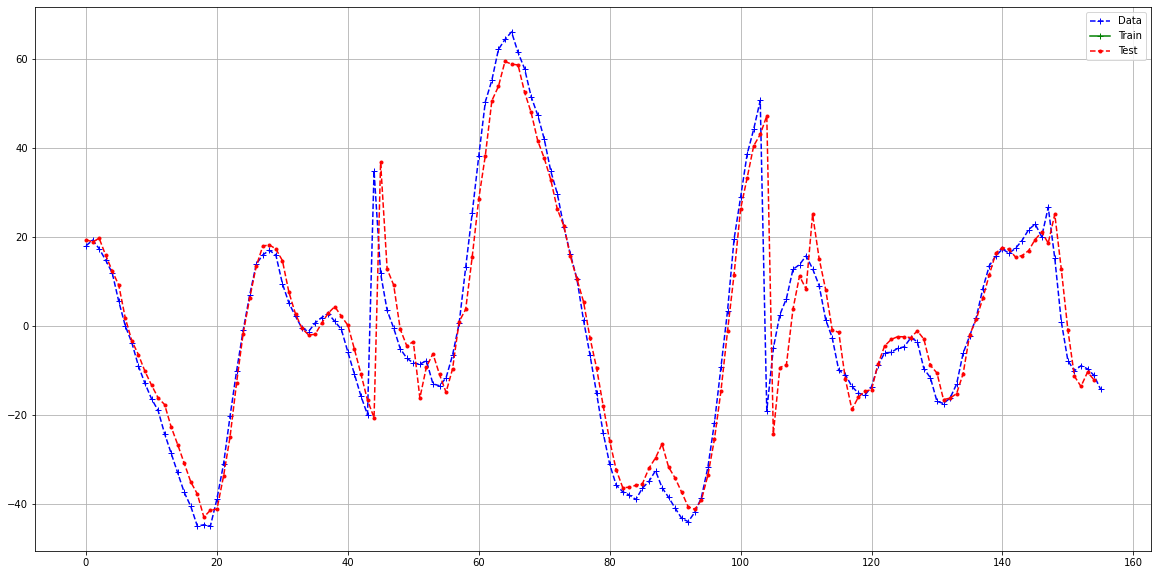

In [50]:
(
    x_train_predict_RNN,
    y_train_RNN,
    x_test_predict_RNN,
    y_test_RNN,
    res,
) = time_series_deep_learning(
    train_x, train_y, test_x, test_y, model_dl=SimpleRNN, unit=12, look_back=20
)

plotting_predictions(dataset, look_back, x_train_predict_RNN, x_test_predict_RNN)

df_results = df_results.append(res)

Stacked Model
Train
The mean absolute error is: 2.61
The mean squared error is: 18.92
Test
The mean absolute error is: 5.56
The mean squared error is: 80.88


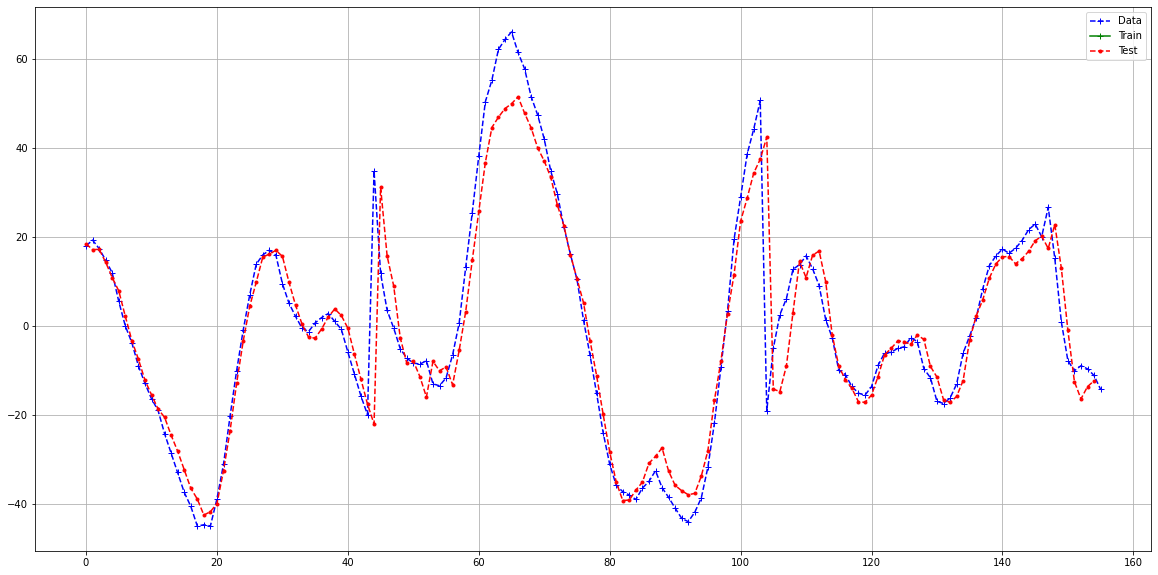

In [51]:
(
    x_train_predict_RNN,
    y_train_RNN,
    x_test_predict_RNN,
    y_test_RNN,
    res,
) = time_series_deep_learning(
    train_x,
    train_y,
    test_x,
    test_y,
    model_dl=SimpleRNN,
    unit=12,
    look_back=20,
    stacked=True,
)
plotting_predictions(dataset, look_back, x_train_predict_RNN, x_test_predict_RNN)
df_results = df_results.append(res)

## LSTM

Simple Model
Train
The mean absolute error is: 2.92
The mean squared error is: 21.26
Test
The mean absolute error is: 5.59
The mean squared error is: 76.96


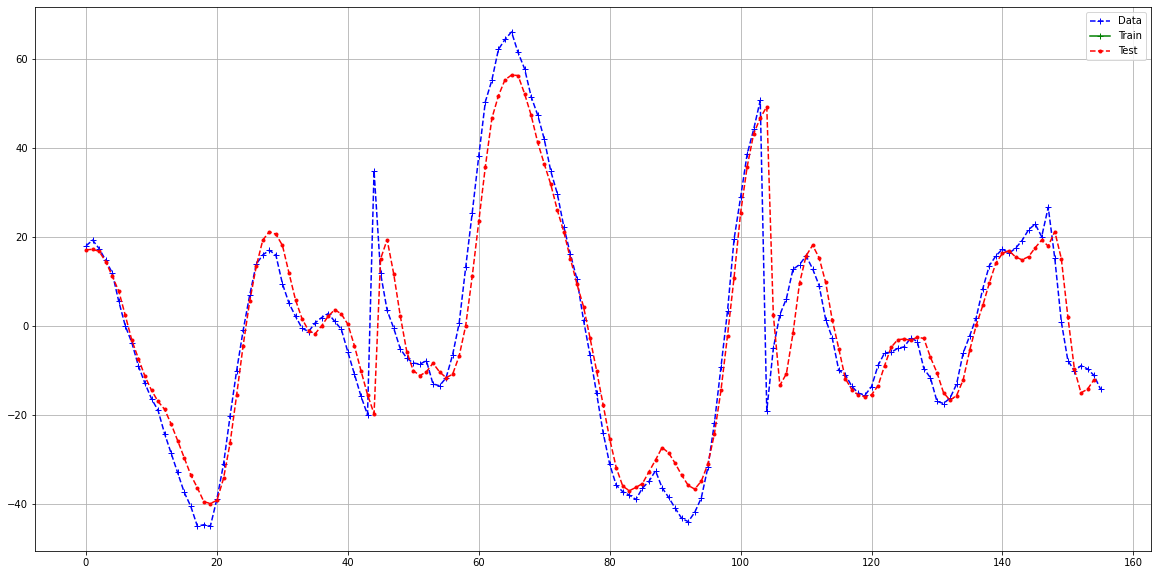

In [52]:
(
    x_train_predict_lstm,
    y_train_lstm,
    x_test_predict_lstm,
    y_test_lstm,
    res,
) = time_series_deep_learning(
    train_x, train_y, test_x, test_y, model_dl=LSTM, unit=12, look_back=20
)
plotting_predictions(dataset, look_back, x_train_predict_lstm, x_test_predict_lstm)
df_results = df_results.append(res)

## GRU

Simple Model
Train
The mean absolute error is: 2.86
The mean squared error is: 20.38
Test
The mean absolute error is: 5.11
The mean squared error is: 71.28


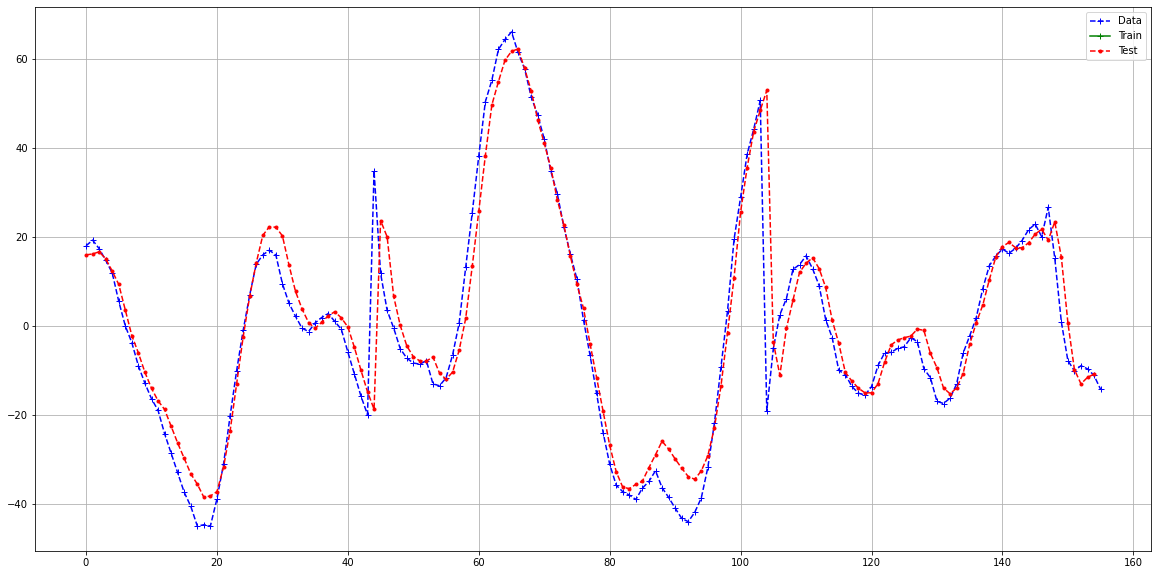

In [53]:
(
    x_train_predict_gru,
    y_train_gru,
    x_test_predict_gru,
    y_test_gru,
    res,
) = time_series_deep_learning(
    train_x, train_y, test_x, test_y, model_dl=GRU, unit=12, look_back=20
)
plotting_predictions(dataset, look_back, x_train_predict_gru, x_test_predict_gru)
df_results = df_results.append(res)

## Stacked LSTMs

In [ ]:
(
    x_train_predict_stack_lstm,
    y_train_stack_lstm,
    x_test_predict_stack_lstm,
    y_test_stack_lstm,
    res,
) = time_series_deep_learning(
    train_x, train_y, test_x, test_y, model_dl=LSTM, unit=12, look_back=20, stacked=True
)
plotting_predictions(
    dataset, look_back, x_train_predict_stack_lstm, x_test_predict_stack_lstm
)
df_results = df_results.append(res)

Stacked Model


## Stacked GRU

In [ ]:
(
    x_train_predict_stack_gru,
    y_train_stack_gru,
    x_test_predict_stack_gru,
    y_test_stack_gru,
    res,
) = time_series_deep_learning(
    train_x, train_y, test_x, test_y, model_dl=GRU, unit=12, look_back=20, stacked=True
)
plotting_predictions(
    dataset, look_back, x_train_predict_stack_gru, x_test_predict_stack_gru
)
df_results = df_results.append(res)

## Bidirectional LSTM

In [ ]:
(
    x_train_predict_biLSTM,
    y_train_biLSTM,
    x_test_predict_biLSTM,
    y_test_biLSTM,
    res,
) = time_series_deep_learning(
    train_x,
    train_y,
    test_x,
    test_y,
    model_dl=LSTM,
    unit=12,
    look_back=20,
    stacked=False,
    bidirection=True,
)
plotting_predictions(dataset, look_back, x_train_predict_biLSTM, x_test_predict_biLSTM)
df_results = df_results.append(res)

## Bidirectional GRU

In [ ]:
(
    x_train_predict_biGRU,
    y_train_biGRU,
    x_test_predict_biGRU,
    y_test_biGRU,
    res,
) = time_series_deep_learning(
    train_x,
    train_y,
    test_x,
    test_y,
    model_dl=GRU,
    unit=12,
    look_back=20,
    stacked=False,
    bidirection=True,
)
plotting_predictions(dataset, look_back, x_train_predict_biGRU, x_test_predict_biGRU)
df_results = df_results.append(res)

## Stacked BiLSTM

In [ ]:
(
    x_train_predict_stack_biLSTM,
    y_train_stack_biLSTM,
    x_test_predict_stack_biLSTM,
    y_test_stack_biLSTM,
    res,
) = time_series_deep_learning(
    train_x,
    train_y,
    test_x,
    test_y,
    model_dl=LSTM,
    unit=12,
    look_back=20,
    stacked=True,
    bidirection=True,
)
plotting_predictions(
    dataset, look_back, x_train_predict_stack_biLSTM, x_test_predict_stack_biLSTM
)
df_results = df_results.append(res)

## Stacked BiGRU

In [ ]:
(
    x_train_predict_stack_biGRU,
    y_train_stack_biGRU,
    x_test_predict_stack_biGRU,
    y_test_stack_biGRU,
    res,
) = time_series_deep_learning(
    train_x,
    train_y,
    test_x,
    test_y,
    model_dl=GRU,
    unit=12,
    look_back=20,
    stacked=True,
    bidirection=True,
)
plotting_predictions(
    dataset, look_back, x_train_predict_stack_biGRU, x_test_predict_stack_biGRU
)
df_results = df_results.append(res)

In [ ]:
df_results.sort_values(by=["mae_test", "mse_test"], ascending=True)

## CNN-LSTM

In [ ]:
(
    x_train_predict_cnn_lstm,
    y_train_cnn_lstm,
    x_test_predict_cnn_lstm,
    y_test_cnn_lstm,
    res,
) = time_series_deep_learning(
    train_x, train_y, test_x, test_y, model_dl=LSTM, unit=12, look_back=20, cnn=True
)
plotting_predictions(dataset, look_back, x_train_predict_lstm, x_test_predict_lstm)
df_results = df_results.append(res)

## CNN-GRU

In [ ]:
(
    x_train_predict_cnn_gru,
    y_train_cnn_gru,
    x_test_predict_cnn_gru,
    y_test_cnn_gru,
    res,
) = time_series_deep_learning(
    train_x, train_y, test_x, test_y, model_dl=GRU, unit=12, look_back=20, cnn=True
)
plotting_predictions(
    dataset, look_back, x_train_predict_cnn_gru, x_test_predict_cnn_gru
)
df_results = df_results.append(res)

In [ ]:
(
    x_train_predict_stack_cnn_gru,
    y_train_stack_cnn_gru,
    x_test_predict_stack_cnn_gru,
    y_test_stack_cnn_gru,
    res,
) = time_series_deep_learning(
    train_x,
    train_y,
    test_x,
    test_y,
    model_dl=GRU,
    unit=5,
    look_back=20,
    cnn=True,
    stacked=True,
)
plotting_predictions(
    dataset, look_back, x_train_predict_stack_cnn_gru, x_test_predict_stack_cnn_gru
)
df_results = df_results.append(res)